# DL/DLOps (2023)
## Lab Assignment 4: RNN 

In [183]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms,models
import numpy as np
import matplotlib.pyplot as plt
import tqdm as notebook_tqdm
from sklearn import metrics

In [184]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

path = '../downloads/language_names'

def findFiles(path): return glob.glob(path)

print(findFiles(path+'/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(path+'/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(f'Data loaded : Category size: {len(all_categories)}')


['../downloads/language_names/names\\Arabic.txt', '../downloads/language_names/names\\Chinese.txt', '../downloads/language_names/names\\Czech.txt', '../downloads/language_names/names\\Dutch.txt', '../downloads/language_names/names\\English.txt', '../downloads/language_names/names\\French.txt', '../downloads/language_names/names\\German.txt', '../downloads/language_names/names\\Greek.txt', '../downloads/language_names/names\\Irish.txt', '../downloads/language_names/names\\Italian.txt', '../downloads/language_names/names\\Japanese.txt', '../downloads/language_names/names\\Korean.txt', '../downloads/language_names/names\\Polish.txt', '../downloads/language_names/names\\Portuguese.txt', '../downloads/language_names/names\\Russian.txt', '../downloads/language_names/names\\Scottish.txt', '../downloads/language_names/names\\Spanish.txt', '../downloads/language_names/names\\Vietnamese.txt']
Slusarski
Data loaded : Category size: 18


In [185]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.

In [186]:

all_data = []
labels = []

for i,c in enumerate(all_categories):
    print(f'category: {c} | category_lines size: {len(category_lines[c])}')
    for n in category_lines[c]:
        all_data.append(lineToTensor(n))
        labels.append(torch.tensor([i], dtype=torch.long))



category: Arabic | category_lines size: 2000
category: Chinese | category_lines size: 268
category: Czech | category_lines size: 519
category: Dutch | category_lines size: 297
category: English | category_lines size: 3668
category: French | category_lines size: 277
category: German | category_lines size: 724
category: Greek | category_lines size: 203
category: Irish | category_lines size: 232
category: Italian | category_lines size: 709
category: Japanese | category_lines size: 991
category: Korean | category_lines size: 94
category: Polish | category_lines size: 139
category: Portuguese | category_lines size: 74
category: Russian | category_lines size: 9408
category: Scottish | category_lines size: 100
category: Spanish | category_lines size: 298
category: Vietnamese | category_lines size: 73


# 1. Split the data into train, val, and test (80:10:10).

In [187]:
from sklearn.model_selection import train_test_split
import numpy as np

#all_data = np.array(all_data)
#labels = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(all_data, labels, test_size=0.2, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(f'training size: {len(x_train)}')
print(f'validation size: {len(x_val)}')
print(f'test size: {len(x_test)}')

training size: 16059
validation size: 2007
test size: 2008


# RNN Model Architechture

In [188]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, linear_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.linear_size = linear_size

        self.i2lh = nn.Linear(input_size + hidden_size, linear_size)
        self.l2h = nn.Linear(linear_size, hidden_size)
        self.i2lo = nn.Linear(input_size + hidden_size, linear_size)
        self.l2o = nn.Linear(linear_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2lh(combined)
        hidden = self.tanh(hidden)
        hidden = self.l2h(hidden)
        hidden = self.tanh(hidden)
        output = self.i2lo(combined)
        output = self.tanh(output)
        output = self.l2o(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def evaluate(self,line_tensor):
        hidden = self.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = self(line_tensor[i], hidden)

        return output

    def predict(self,input_line, n_predictions=3):
        print('\n> %s' % input_line)
        with torch.no_grad():
            output = self.evaluate(lineToTensor(input_line))

            # Get top N categories
            topv, topi = output.topk(n_predictions, 1, True)
            predictions = []

            for i in range(n_predictions):
                value = topv[0][i].item()
                category_index = topi[0][i].item()
                print('(%.2f) %s' % (value, all_categories[category_index]))
                predictions.append([value, all_categories[category_index]])


In [191]:
def plot_training_graphs(loss_list):
    fig = plt.figure(figsize =(20,7))
    plot = fig.add_subplot(1, 2, 1)
    plot.set_title("Training vs Validation loss")
    plot.plot(loss_list[:,0], linestyle='--', label="Training Loss")
    plot.plot(loss_list[:,1], linestyle='-', label="Validation Loss" )
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Loss")
    plot.legend()
    plot = fig.add_subplot(1, 2, 2)
    plot.set_title("Training vs Validation Accuracy")
    plot.plot(loss_list[:,2], linestyle='--', label="Training Accuracy")
    plot.plot(loss_list[:,3], linestyle='-', label="Validation Accuracy" )
    plot.set_xlabel("Epoch")
    plot.set_ylabel("Accuracy")
    plot.legend()
    plt.show()

In [204]:
import time
import math
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [230]:
# Train the model
def model_training(rnn,criterion,optimizer,x_train,y_train,x_val,y_val,num_epochs = 10):
    start = time.time()
    loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for i,line_tensor in enumerate(x_train):
            category_tensor =y_train[i]
            hidden = rnn.initHidden()
            rnn.zero_grad()
            # Forward pass
            for i in range(line_tensor.size()[0]):
                outputs, hidden = rnn(line_tensor[i], hidden)

            loss = criterion(outputs, category_tensor)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += metrics.accuracy_score(category_tensor,outputs.argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            #images, labels = next(iter(testloader))
            for i,line_tensor in enumerate(x_val):
                outputs = rnn.evaluate(line_tensor)
                loss = criterion(outputs, y_val[i])
                val_loss += loss.item()
                val_acc += metrics.accuracy_score(y_val[i],outputs.argmax(axis=1))
        train_loss = train_loss/len(x_train)
        val_loss = val_loss/len(x_val)
        train_acc = train_acc/len(x_train)
        val_acc = val_acc/len(x_val)
        print(f'Epoch: {epoch+1} ({timeSince(start)}) \tTraining Loss: {train_loss:.3f}, \tTest Loss: {val_loss:.3f},  \tTraining acc: {train_acc:.2f}, \tTest acc: {val_acc:.2f}, ')
        loss_list.append([train_loss,val_loss,train_acc,val_acc])
    
    print(f'Training completed in {timeSince(start)} \tTraining Loss: {loss_list[-1][0]:.3f}, \tTest Loss: {loss_list[-1][1]:.3f},  \tTraining acc: {loss_list[-1][2]:.2f}, \tTest acc: {loss_list[-1][3]:.2f}, ')
    return np.array(loss_list)


In [243]:
from sklearn import metrics
import seaborn as sns
#sns.set(rc={'axes.facecolor': 'lightblue', 'figure.facecolor': 'lightblue'})

def confusionMatrixAndAccuracyReport(Y_test, Y_pred_probs, label):
    Y_pred = Y_pred_probs.argmax(axis=1)
    cm = metrics.confusion_matrix(Y_test, Y_pred)
    overallAccuracy = metrics.accuracy_score(Y_test, Y_pred)

    classwiseAccuracy = cm.diagonal()/cm.sum(axis=1)

    top_5_accuracy = metrics.top_k_accuracy_score(Y_test,Y_pred_probs,k=5,labels=np.arange(len(label)))

    plt.figure(figsize=(12, 10))
    plt.title(f'Top 1 Accuracy : {overallAccuracy*100:3.2f}% | Top 5 Accuracy : {top_5_accuracy*100:3.2f}% ', size=14)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    sns.heatmap(data=cm, annot=True, square=True,  cmap='Blues', fmt='g')

    plt.show()
    print(f'Top 1 Accuracy: {overallAccuracy*100:3.3f}%')
    print(f'Top 5 Accuracy: {top_5_accuracy*100}%')
    print(f'Classwise Accuracy Score: \n{classwiseAccuracy}')

    #print(metrics.classification_report(Y_test, Y_pred))

In [196]:
def list_to_nparray(list_of_tensors):
    return np.array([x[0].numpy() for x in list_of_tensors])

## 2. Plot the epoch vs. loss curve for training and validation data. Save your best model after appropriate hyperparameter tuning. [5]

#### Trying with different Optimizers

1. Adam

Epoch: 1 (0m 59s) 	Training Loss: 2.330, 	Test Loss: 2.120,  	Training acc: 0.37, 	Test acc: 0.34, 
Epoch: 2 (2m 6s) 	Training Loss: 2.309, 	Test Loss: 2.093,  	Training acc: 0.38, 	Test acc: 0.48, 
Epoch: 3 (3m 20s) 	Training Loss: 2.326, 	Test Loss: 2.151,  	Training acc: 0.38, 	Test acc: 0.49, 
Epoch: 4 (4m 27s) 	Training Loss: 2.292, 	Test Loss: 2.130,  	Training acc: 0.38, 	Test acc: 0.48, 
Epoch: 5 (5m 41s) 	Training Loss: 2.298, 	Test Loss: 2.038,  	Training acc: 0.39, 	Test acc: 0.49, 
Epoch: 6 (7m 0s) 	Training Loss: 2.319, 	Test Loss: 2.053,  	Training acc: 0.38, 	Test acc: 0.48, 
Epoch: 7 (8m 17s) 	Training Loss: 2.316, 	Test Loss: 2.033,  	Training acc: 0.38, 	Test acc: 0.49, 
Epoch: 8 (9m 37s) 	Training Loss: 2.242, 	Test Loss: 2.038,  	Training acc: 0.39, 	Test acc: 0.49, 
Epoch: 9 (11m 16s) 	Training Loss: 2.302, 	Test Loss: 2.466,  	Training acc: 0.38, 	Test acc: 0.21, 
Epoch: 10 (12m 47s) 	Training Loss: 2.296, 	Test Loss: 2.157,  	Training acc: 0.38, 	Test acc: 0.23, 

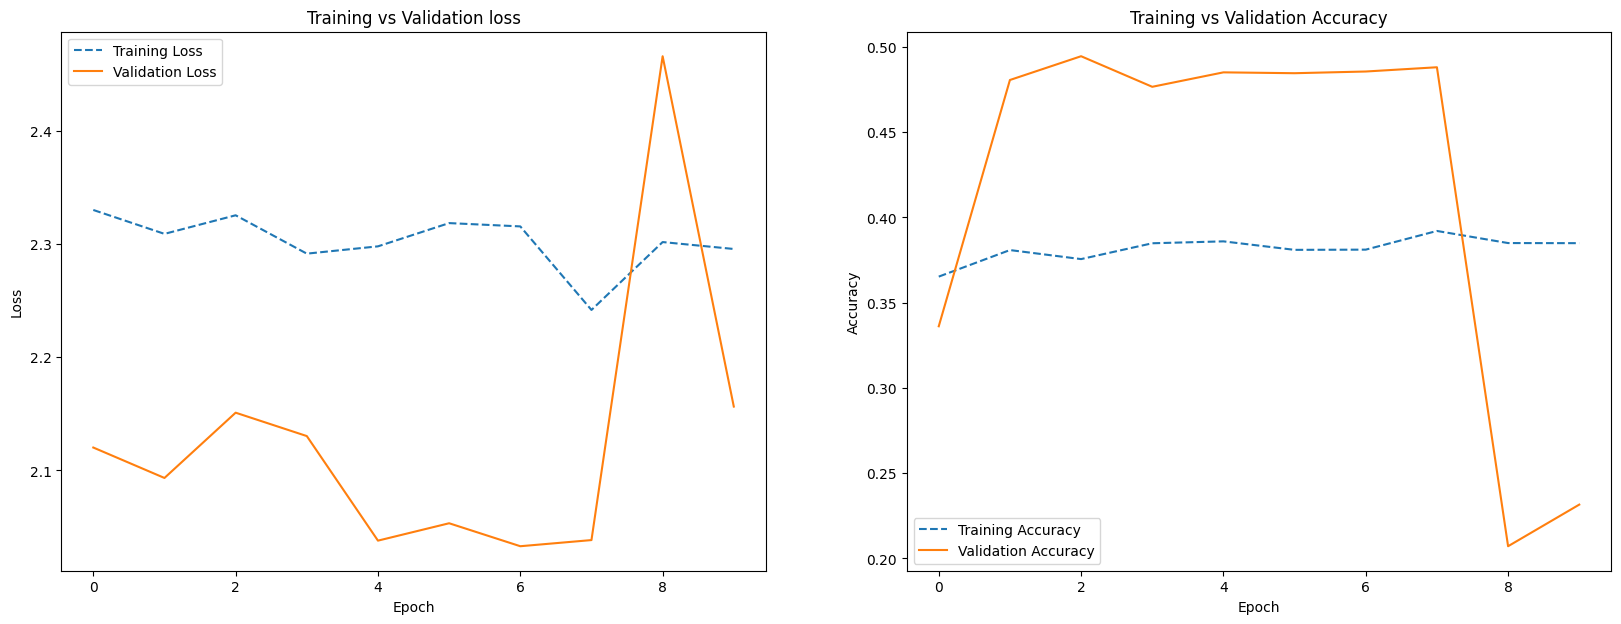

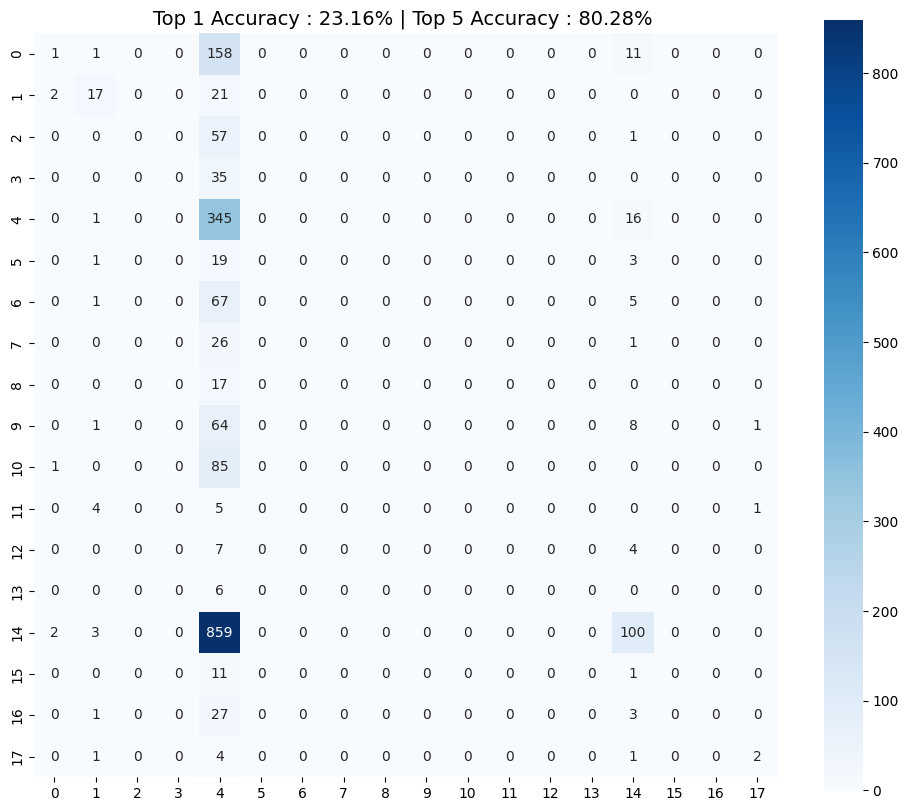

Top 1 Accuracy: 23.157%
Top 5 Accuracy: 80.2788844621514%
Classwise Accuracy Score: 
[0.00584795 0.425      0.         0.         0.95303867 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.10373444 0.         0.         0.25      ]


In [234]:
criterion = nn.NLLLoss()
learning_rate = 0.005
n_hidden = 128
n_linear = 128
rnn = RNN(n_letters, n_hidden,n_linear, n_categories)
optimizer = torch.optim.Adam(rnn.parameters(),lr= learning_rate)
loss_list = model_training(rnn,criterion,optimizer,x_train,y_train,x_test,y_test,num_epochs=10)
plot_training_graphs(loss_list)


with torch.no_grad(): 

    test_output =[]
    for i,line_tensor in enumerate(x_test):  
            test_output.append(rnn.evaluate(line_tensor))

    confusionMatrixAndAccuracyReport(list_to_nparray(y_test),list_to_nparray(test_output),all_categories)

2. Adagrad

Epoch: 1 (0m 53s) 	Training Loss: 1.311, 	Test Loss: 1.168,  	Training acc: 0.62, 	Test acc: 0.66, 
Epoch: 2 (1m 40s) 	Training Loss: 1.075, 	Test Loss: 1.074,  	Training acc: 0.70, 	Test acc: 0.69, 
Epoch: 3 (2m 25s) 	Training Loss: 1.010, 	Test Loss: 1.027,  	Training acc: 0.72, 	Test acc: 0.70, 
Epoch: 4 (3m 12s) 	Training Loss: 0.973, 	Test Loss: 0.997,  	Training acc: 0.72, 	Test acc: 0.70, 
Epoch: 5 (4m 2s) 	Training Loss: 0.947, 	Test Loss: 0.975,  	Training acc: 0.73, 	Test acc: 0.71, 
Epoch: 6 (4m 48s) 	Training Loss: 0.926, 	Test Loss: 0.956,  	Training acc: 0.73, 	Test acc: 0.72, 
Epoch: 7 (5m 32s) 	Training Loss: 0.907, 	Test Loss: 0.940,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 8 (6m 31s) 	Training Loss: 0.891, 	Test Loss: 0.925,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 9 (7m 24s) 	Training Loss: 0.876, 	Test Loss: 0.913,  	Training acc: 0.74, 	Test acc: 0.74, 
Epoch: 10 (8m 12s) 	Training Loss: 0.863, 	Test Loss: 0.903,  	Training acc: 0.75, 	Test acc: 0.74, 


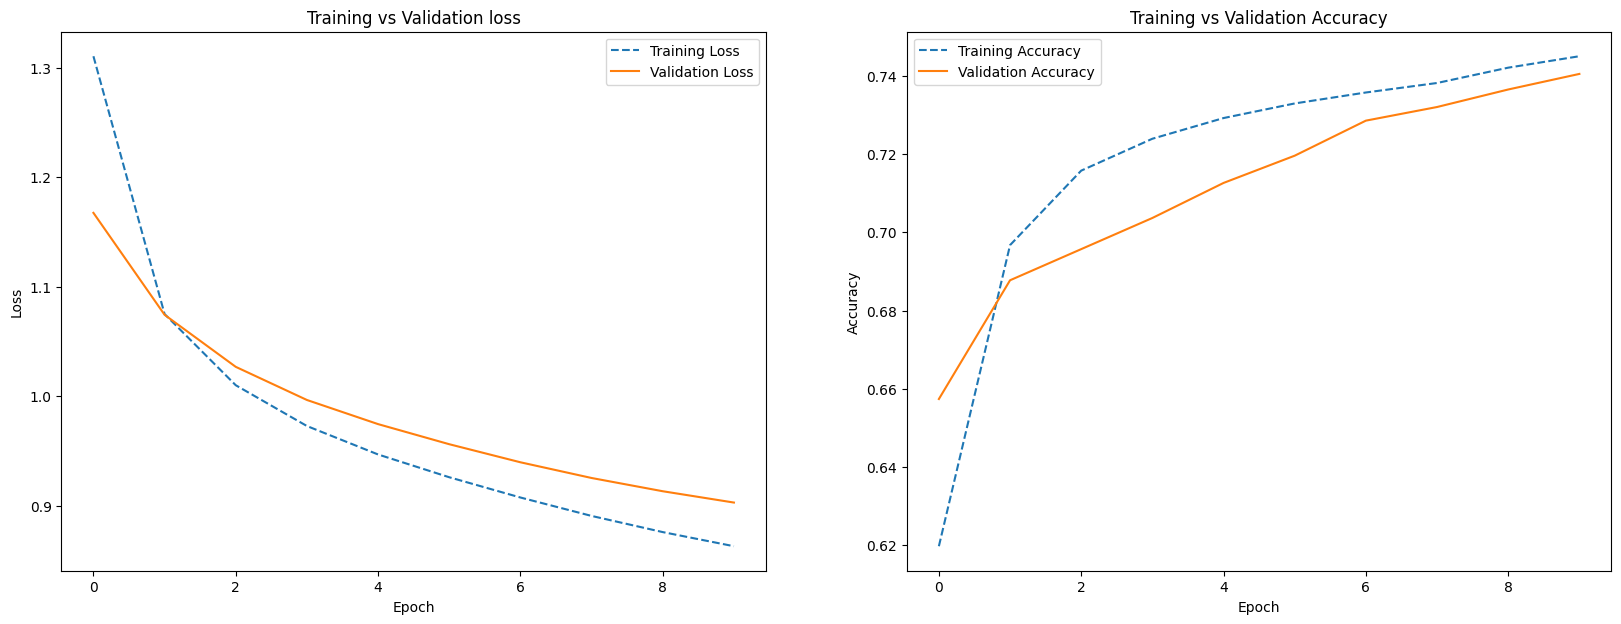

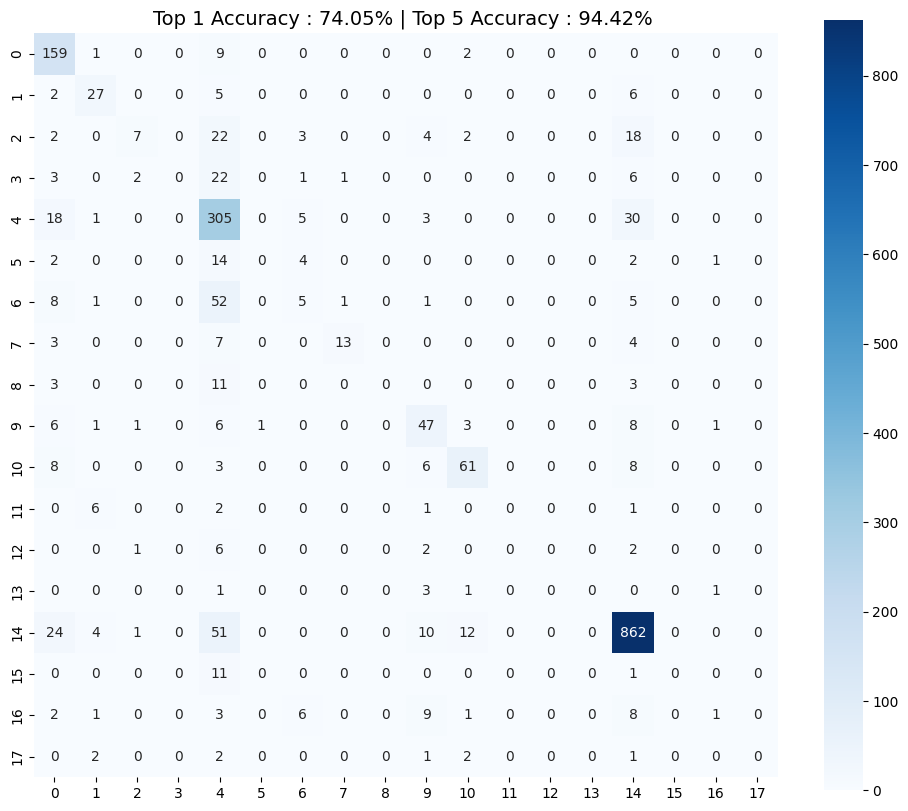

Top 1 Accuracy: 74.054%
Top 5 Accuracy: 94.42231075697211%
Classwise Accuracy Score: 
[0.92982456 0.675      0.12068966 0.         0.84254144 0.
 0.06849315 0.48148148 0.         0.63513514 0.70930233 0.
 0.         0.         0.89419087 0.         0.03225806 0.        ]


In [233]:
criterion = nn.NLLLoss()
learning_rate = 0.005
n_hidden = 128
n_linear = 128
rnn = RNN(n_letters, n_hidden,n_linear, n_categories)
optimizer = torch.optim.Adagrad(rnn.parameters(),lr= learning_rate)
loss_list = model_training(rnn,criterion,optimizer,x_train,y_train,x_test,y_test,num_epochs=10)
plot_training_graphs(loss_list)


with torch.no_grad(): 

    test_output =[]
    for i,line_tensor in enumerate(x_test):  
            test_output.append(rnn.evaluate(line_tensor))

    confusionMatrixAndAccuracyReport(list_to_nparray(y_test),list_to_nparray(test_output),all_categories)

3. SGD

Epoch: 1 	Training Loss: 9.503926, 	Test Loss: 2454.252786,  	Training acc: 0.566660, 	Test acc: 0.644920, 
Epoch: 2 	Training Loss: 7.143249, 	Test Loss: 2158.361900,  	Training acc: 0.671212, 	Test acc: 0.667331, 
Epoch: 3 	Training Loss: 6.492329, 	Test Loss: 2013.709076,  	Training acc: 0.699172, 	Test acc: 0.688745, 
Epoch: 4 	Training Loss: 6.153968, 	Test Loss: 1933.678433,  	Training acc: 0.710505, 	Test acc: 0.703685, 
Epoch: 5 	Training Loss: 5.931814, 	Test Loss: 1872.248697,  	Training acc: 0.717977, 	Test acc: 0.706175, 
Epoch: 6 	Training Loss: 5.766044, 	Test Loss: 1833.193671,  	Training acc: 0.724516, 	Test acc: 0.718625, 
Epoch: 7 	Training Loss: 5.635828, 	Test Loss: 1799.748003,  	Training acc: 0.729871, 	Test acc: 0.721116, 
Epoch: 8 	Training Loss: 5.591730, 	Test Loss: 1780.246930,  	Training acc: 0.729933, 	Test acc: 0.729582, 
Epoch: 9 	Training Loss: 5.393053, 	Test Loss: 1718.860302,  	Training acc: 0.739772, 	Test acc: 0.731574, 
Epoch: 10 	Training Loss: 5.

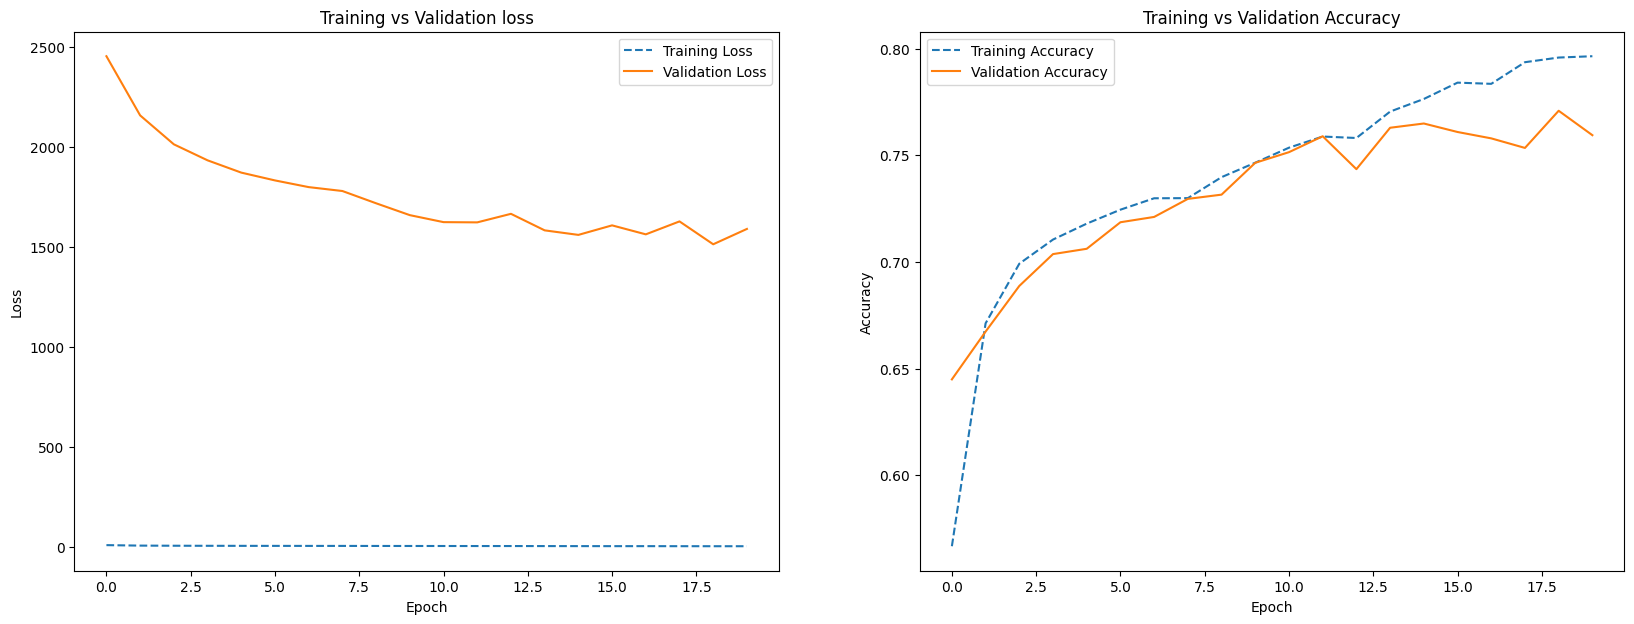

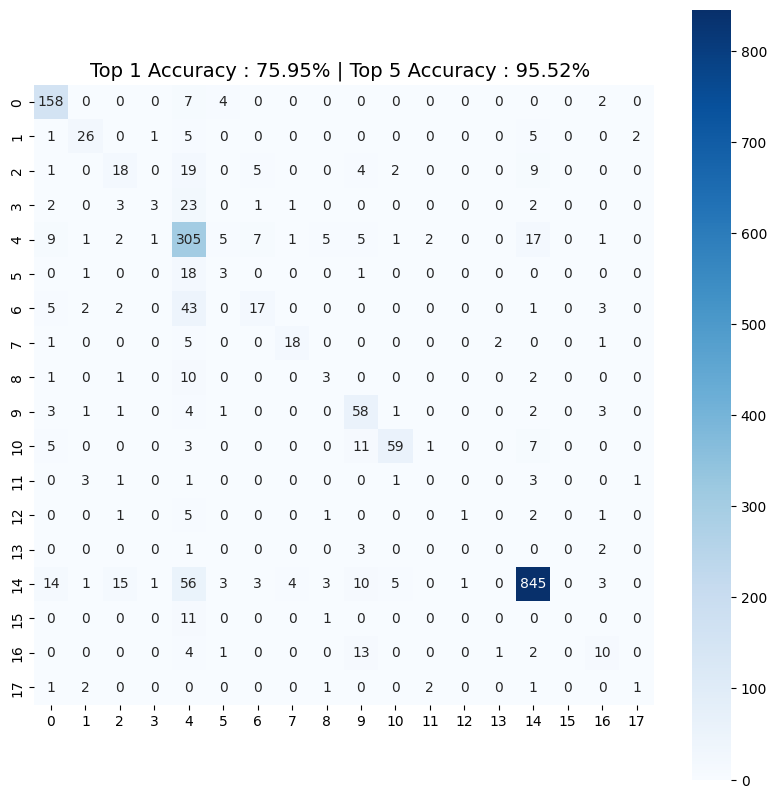

Top 1 Accuracy: 75.946%
Top 5 Accuracy: 95.5179282868526%
Classwise Accuracy Score: 
[0.92397661 0.65       0.31034483 0.08571429 0.84254144 0.13043478
 0.23287671 0.66666667 0.17647059 0.78378378 0.68604651 0.
 0.09090909 0.         0.87655602 0.         0.32258065 0.125     ]


In [199]:
criterion = nn.NLLLoss()
learning_rate = 0.005
n_hidden = 128
n_linear = 128
rnn = RNN(n_letters, n_hidden,n_linear, n_categories)
optimizer = torch.optim.SGD(rnn.parameters(),lr= learning_rate)
loss_list = model_training(rnn,criterion,optimizer,x_train,y_train,x_test,y_test,num_epochs=20)
plot_training_graphs(loss_list)


with torch.no_grad(): 

    test_output =[]
    for i,line_tensor in enumerate(x_test):  
            test_output.append(rnn.evaluate(line_tensor))

    confusionMatrixAndAccuracyReport(list_to_nparray(y_test),list_to_nparray(test_output),all_categories)


#### Trying with different hidden layer and linear layer size

Trying n_hidden=512 and n_linear=512 :

Epoch: 1 (4m 26s) 	Training Loss: 1.756, 	Test Loss: 1.481,  	Training acc: 0.47, 	Test acc: 0.54, 
Epoch: 2 (8m 8s) 	Training Loss: 1.429, 	Test Loss: 1.382,  	Training acc: 0.55, 	Test acc: 0.56, 
Epoch: 3 (11m 51s) 	Training Loss: 1.307, 	Test Loss: 1.268,  	Training acc: 0.59, 	Test acc: 0.60, 
Epoch: 4 (15m 33s) 	Training Loss: 1.257, 	Test Loss: 1.223,  	Training acc: 0.60, 	Test acc: 0.63, 
Epoch: 5 (19m 10s) 	Training Loss: 1.182, 	Test Loss: 1.170,  	Training acc: 0.63, 	Test acc: 0.64, 
Epoch: 6 (22m 50s) 	Training Loss: 1.136, 	Test Loss: 1.138,  	Training acc: 0.65, 	Test acc: 0.65, 
Epoch: 7 (26m 39s) 	Training Loss: 1.098, 	Test Loss: 1.113,  	Training acc: 0.66, 	Test acc: 0.66, 
Epoch: 8 (30m 40s) 	Training Loss: 1.060, 	Test Loss: 1.081,  	Training acc: 0.67, 	Test acc: 0.66, 
Epoch: 9 (34m 40s) 	Training Loss: 1.025, 	Test Loss: 1.058,  	Training acc: 0.69, 	Test acc: 0.67, 
Epoch: 10 (38m 40s) 	Training Loss: 0.995, 	Test Loss:

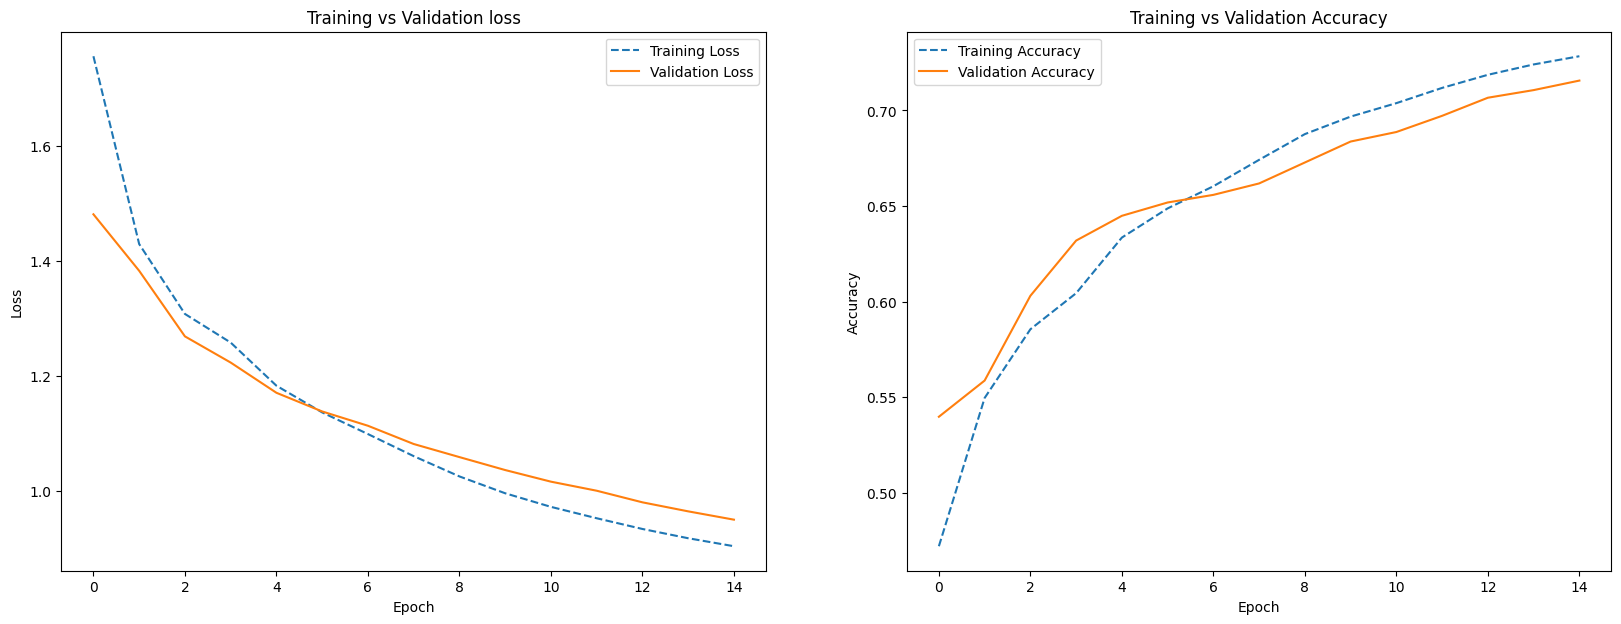

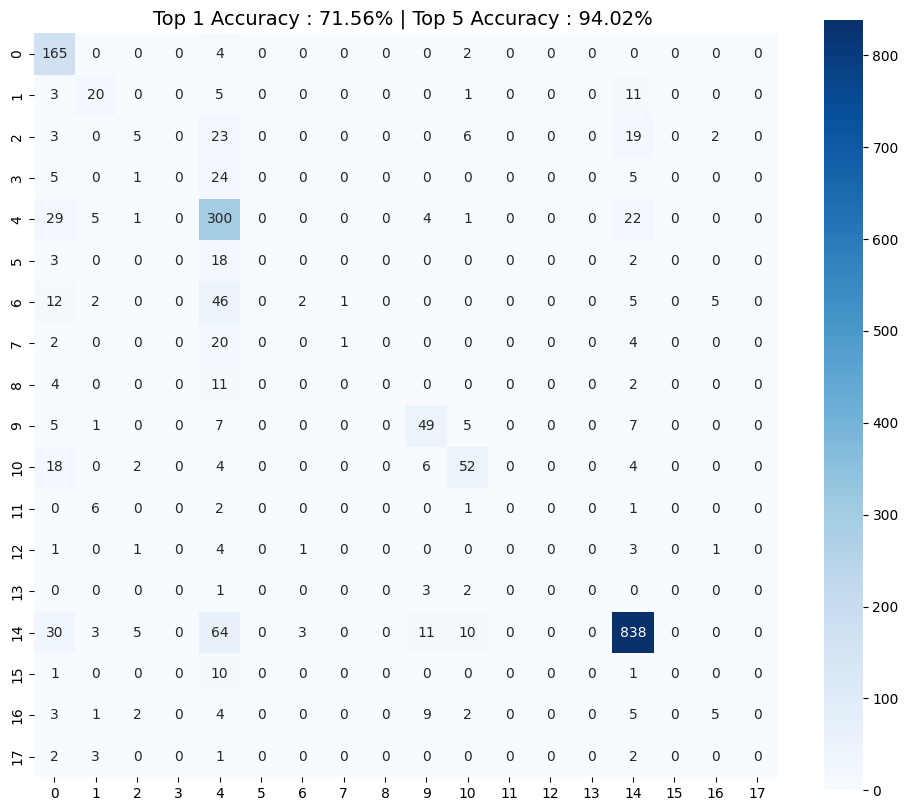

Top 1 Accuracy: 71.564%
Top 5 Accuracy: 94.02390438247012%
Classwise Accuracy Score: 
[0.96491228 0.5        0.0862069  0.         0.82872928 0.
 0.02739726 0.03703704 0.         0.66216216 0.60465116 0.
 0.         0.         0.86929461 0.         0.16129032 0.        ]

	 With n_hidden=512 and n_linear=512 : 	 f1_score=0.675	 accuracy=0.716
Trying n_hidden=512 and n_linear=256 :

Epoch: 1 (1m 13s) 	Training Loss: 1.368, 	Test Loss: 1.139,  	Training acc: 0.60, 	Test acc: 0.67, 
Epoch: 2 (2m 37s) 	Training Loss: 1.038, 	Test Loss: 1.021,  	Training acc: 0.71, 	Test acc: 0.71, 
Epoch: 3 (4m 1s) 	Training Loss: 0.944, 	Test Loss: 0.955,  	Training acc: 0.73, 	Test acc: 0.72, 
Epoch: 4 (5m 25s) 	Training Loss: 0.888, 	Test Loss: 0.914,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 5 (6m 49s) 	Training Loss: 0.850, 	Test Loss: 0.887,  	Training acc: 0.75, 	Test acc: 0.74, 
Epoch: 6 (8m 13s) 	Training Loss: 0.822, 	Test Loss: 0.870,  	Training acc: 0.76, 	Test acc: 0.74, 
Epoch: 7 (9m 37s

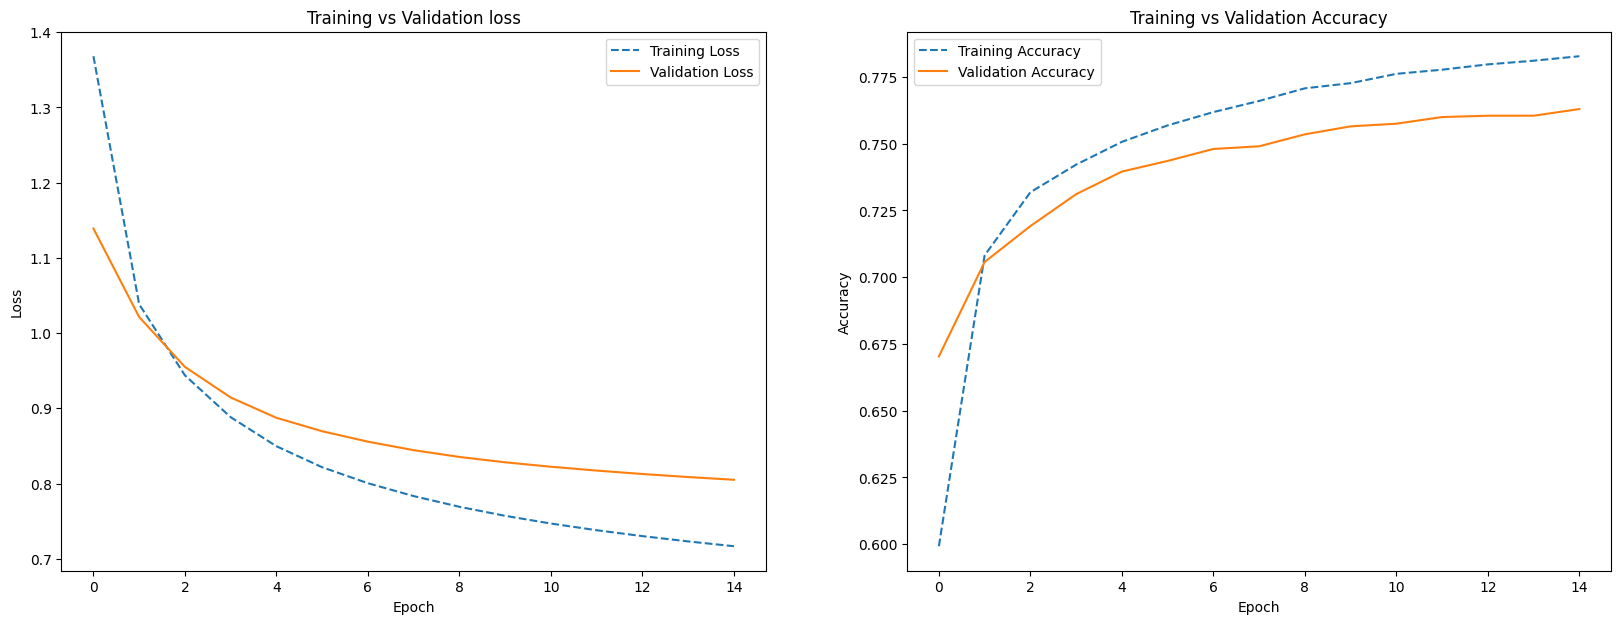

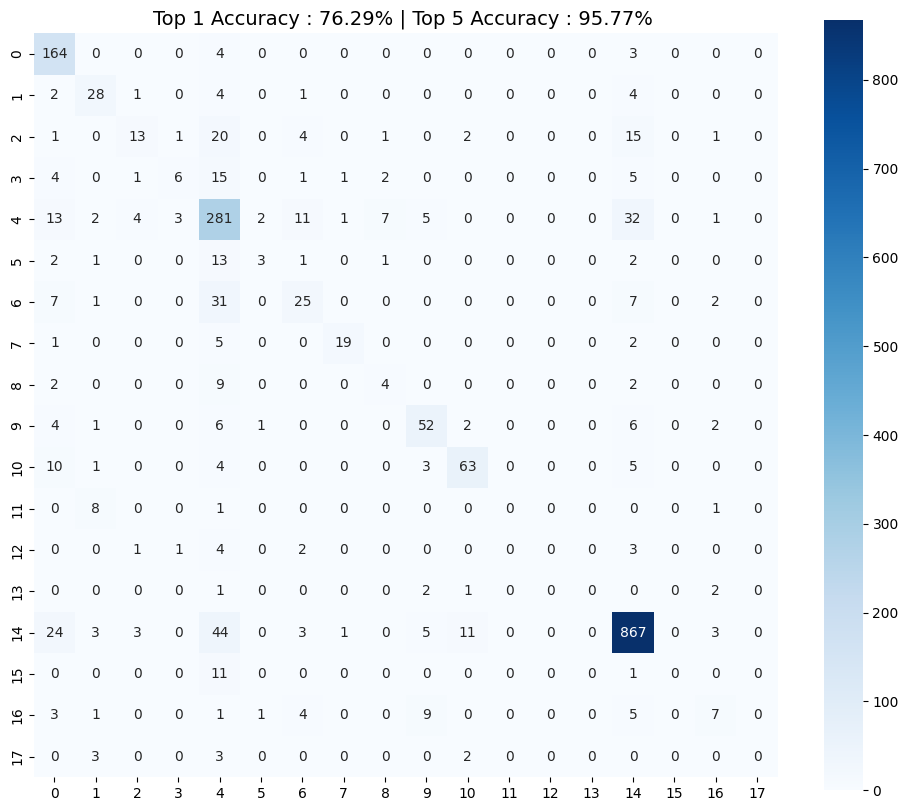

Top 1 Accuracy: 76.295%
Top 5 Accuracy: 95.76693227091634%
Classwise Accuracy Score: 
[0.95906433 0.7        0.22413793 0.17142857 0.77624309 0.13043478
 0.34246575 0.7037037  0.23529412 0.7027027  0.73255814 0.
 0.         0.         0.89937759 0.         0.22580645 0.        ]

	 With n_hidden=512 and n_linear=256 : 	 f1_score=0.743	 accuracy=0.763
Trying n_hidden=512 and n_linear=128 :

Epoch: 1 (1m 6s) 	Training Loss: 1.375, 	Test Loss: 1.180,  	Training acc: 0.60, 	Test acc: 0.66, 
Epoch: 2 (2m 11s) 	Training Loss: 1.087, 	Test Loss: 1.066,  	Training acc: 0.70, 	Test acc: 0.69, 
Epoch: 3 (3m 16s) 	Training Loss: 1.003, 	Test Loss: 1.008,  	Training acc: 0.72, 	Test acc: 0.71, 
Epoch: 4 (4m 22s) 	Training Loss: 0.949, 	Test Loss: 0.967,  	Training acc: 0.73, 	Test acc: 0.72, 
Epoch: 5 (5m 23s) 	Training Loss: 0.909, 	Test Loss: 0.942,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 6 (6m 19s) 	Training Loss: 0.879, 	Test Loss: 0.924,  	Training acc: 0.75, 	Test acc: 0.73, 
Epoch: 7

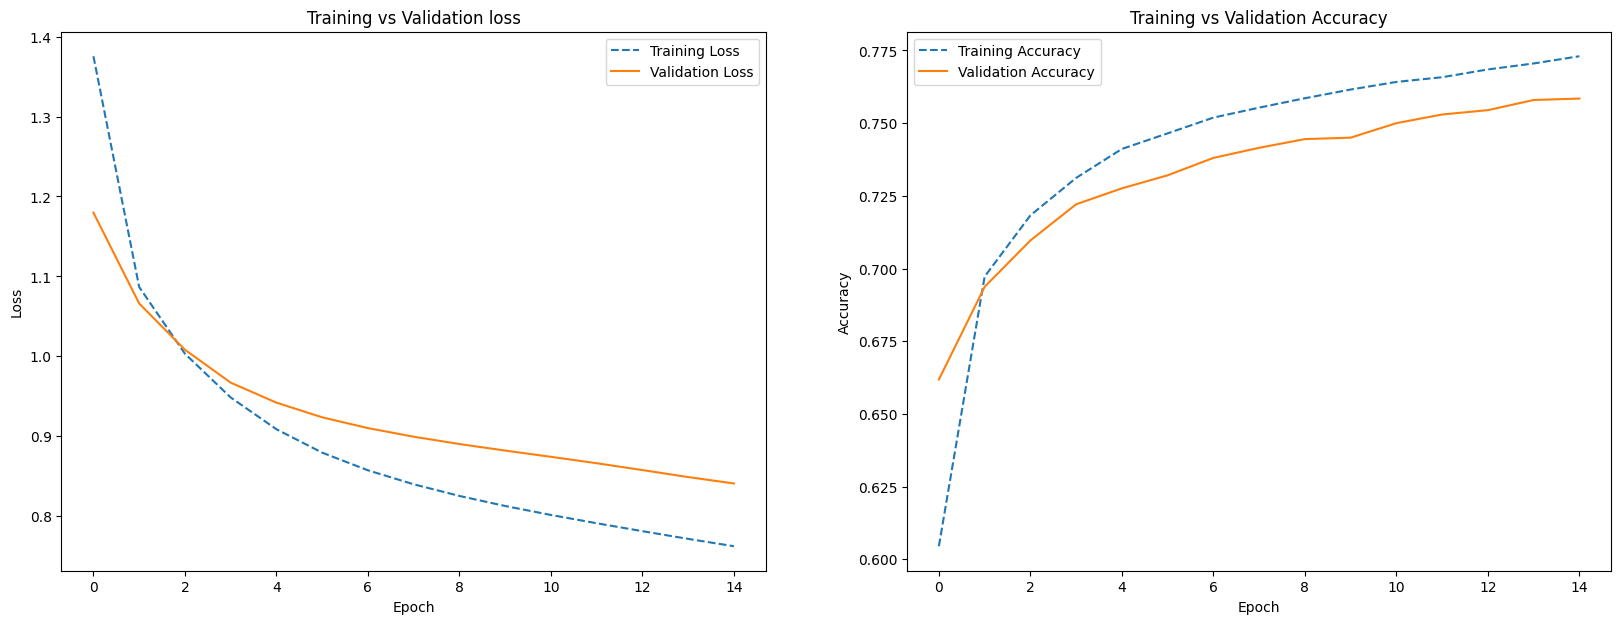

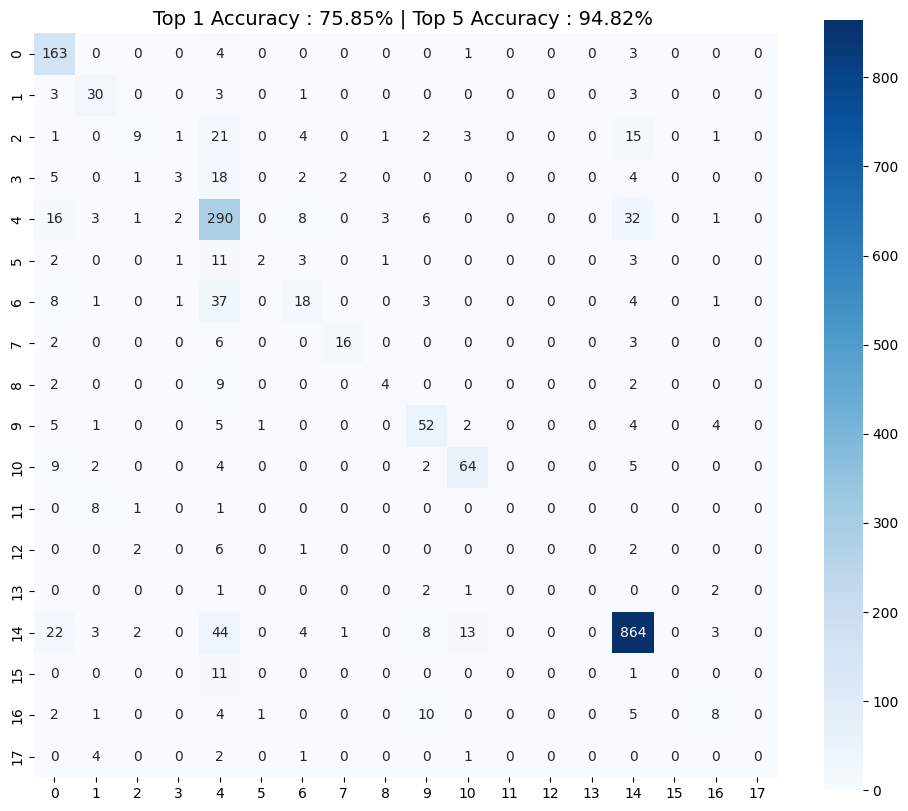

Top 1 Accuracy: 75.847%
Top 5 Accuracy: 94.82071713147411%
Classwise Accuracy Score: 
[0.95321637 0.75       0.15517241 0.08571429 0.80110497 0.08695652
 0.24657534 0.59259259 0.23529412 0.7027027  0.74418605 0.
 0.         0.         0.89626556 0.         0.25806452 0.        ]

	 With n_hidden=512 and n_linear=128 : 	 f1_score=0.734	 accuracy=0.758
Trying n_hidden=512 and n_linear=64 :

Epoch: 1 (0m 49s) 	Training Loss: 1.446, 	Test Loss: 1.257,  	Training acc: 0.58, 	Test acc: 0.63, 
Epoch: 2 (1m 39s) 	Training Loss: 1.172, 	Test Loss: 1.143,  	Training acc: 0.67, 	Test acc: 0.67, 
Epoch: 3 (2m 27s) 	Training Loss: 1.085, 	Test Loss: 1.086,  	Training acc: 0.70, 	Test acc: 0.69, 
Epoch: 4 (3m 15s) 	Training Loss: 1.033, 	Test Loss: 1.048,  	Training acc: 0.71, 	Test acc: 0.70, 
Epoch: 5 (4m 3s) 	Training Loss: 0.995, 	Test Loss: 1.021,  	Training acc: 0.72, 	Test acc: 0.71, 
Epoch: 6 (4m 53s) 	Training Loss: 0.964, 	Test Loss: 0.998,  	Training acc: 0.73, 	Test acc: 0.72, 
Epoch: 7 

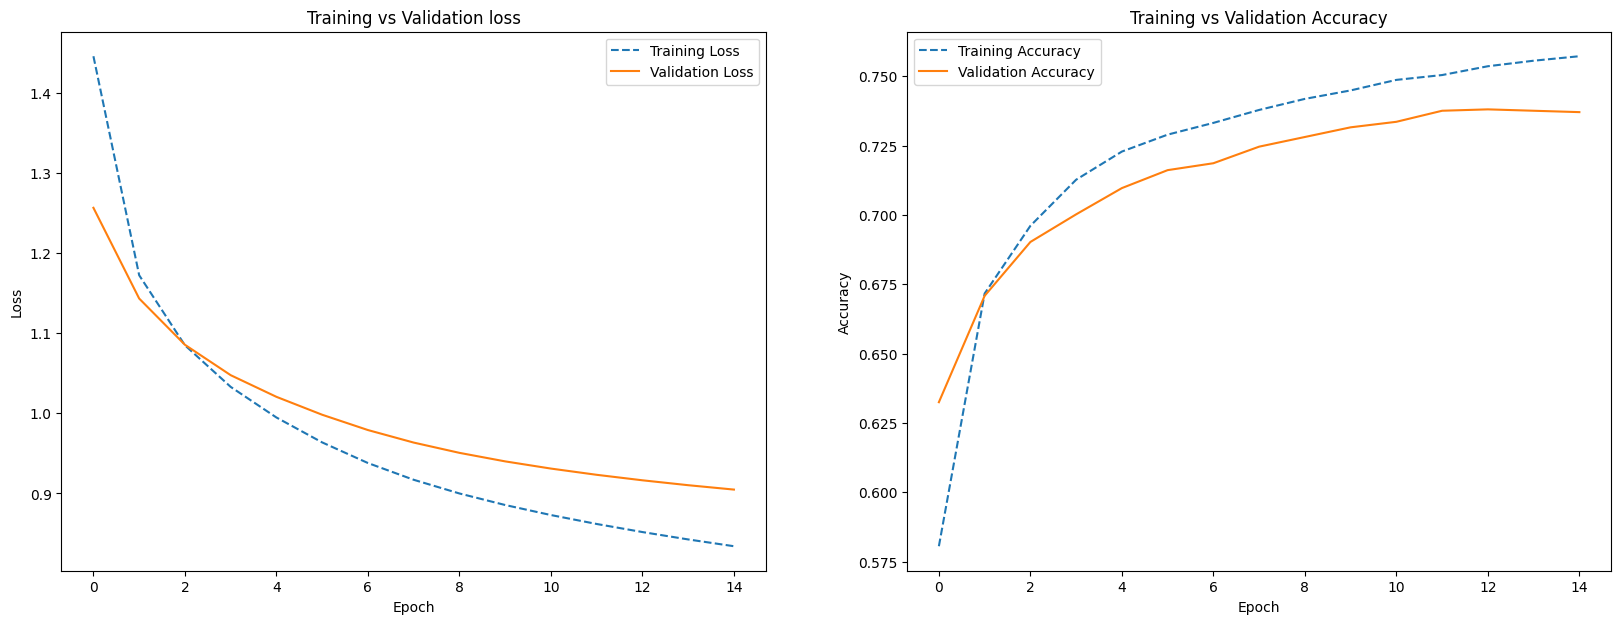

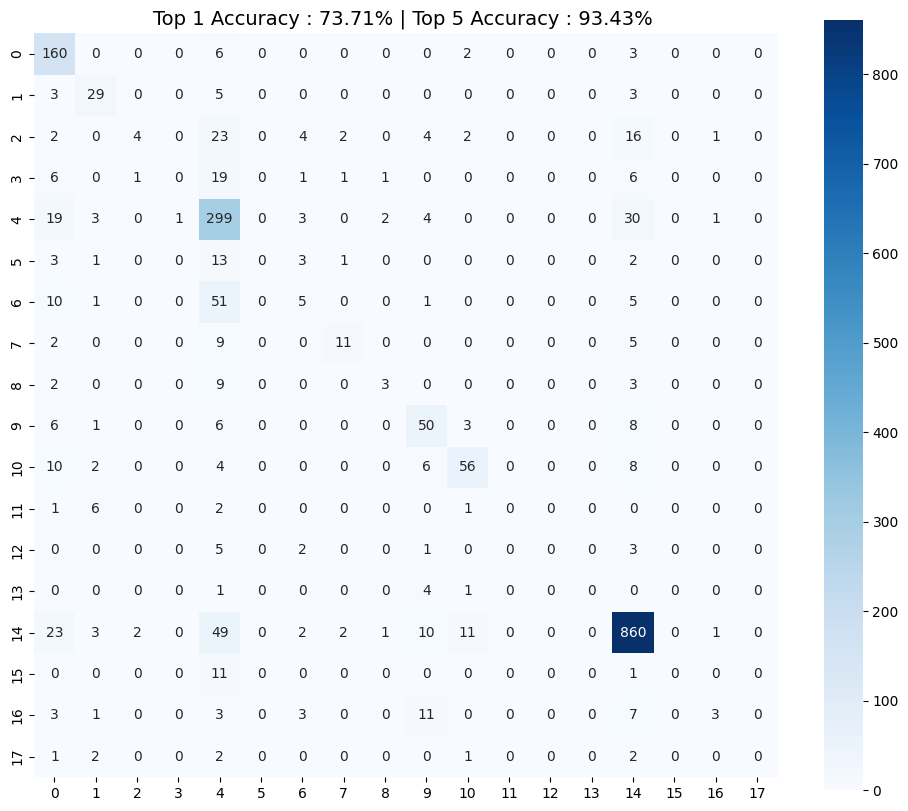

Top 1 Accuracy: 73.705%
Top 5 Accuracy: 93.42629482071713%
Classwise Accuracy Score: 
[0.93567251 0.725      0.06896552 0.         0.82596685 0.
 0.06849315 0.40740741 0.17647059 0.67567568 0.65116279 0.
 0.         0.         0.89211618 0.         0.09677419 0.        ]

	 With n_hidden=512 and n_linear=64 : 	 f1_score=0.699	 accuracy=0.737
Trying n_hidden=256 and n_linear=512 :

Epoch: 1 (1m 29s) 	Training Loss: 1.540, 	Test Loss: 1.292,  	Training acc: 0.52, 	Test acc: 0.61, 
Epoch: 2 (2m 53s) 	Training Loss: 1.235, 	Test Loss: 1.187,  	Training acc: 0.62, 	Test acc: 0.65, 
Epoch: 3 (4m 22s) 	Training Loss: 1.147, 	Test Loss: 1.121,  	Training acc: 0.64, 	Test acc: 0.66, 
Epoch: 4 (5m 49s) 	Training Loss: 1.073, 	Test Loss: 1.056,  	Training acc: 0.67, 	Test acc: 0.68, 
Epoch: 5 (7m 18s) 	Training Loss: 1.000, 	Test Loss: 1.008,  	Training acc: 0.69, 	Test acc: 0.70, 
Epoch: 6 (8m 47s) 	Training Loss: 0.959, 	Test Loss: 0.980,  	Training acc: 0.71, 	Test acc: 0.71, 
Epoch: 7 (10m 15

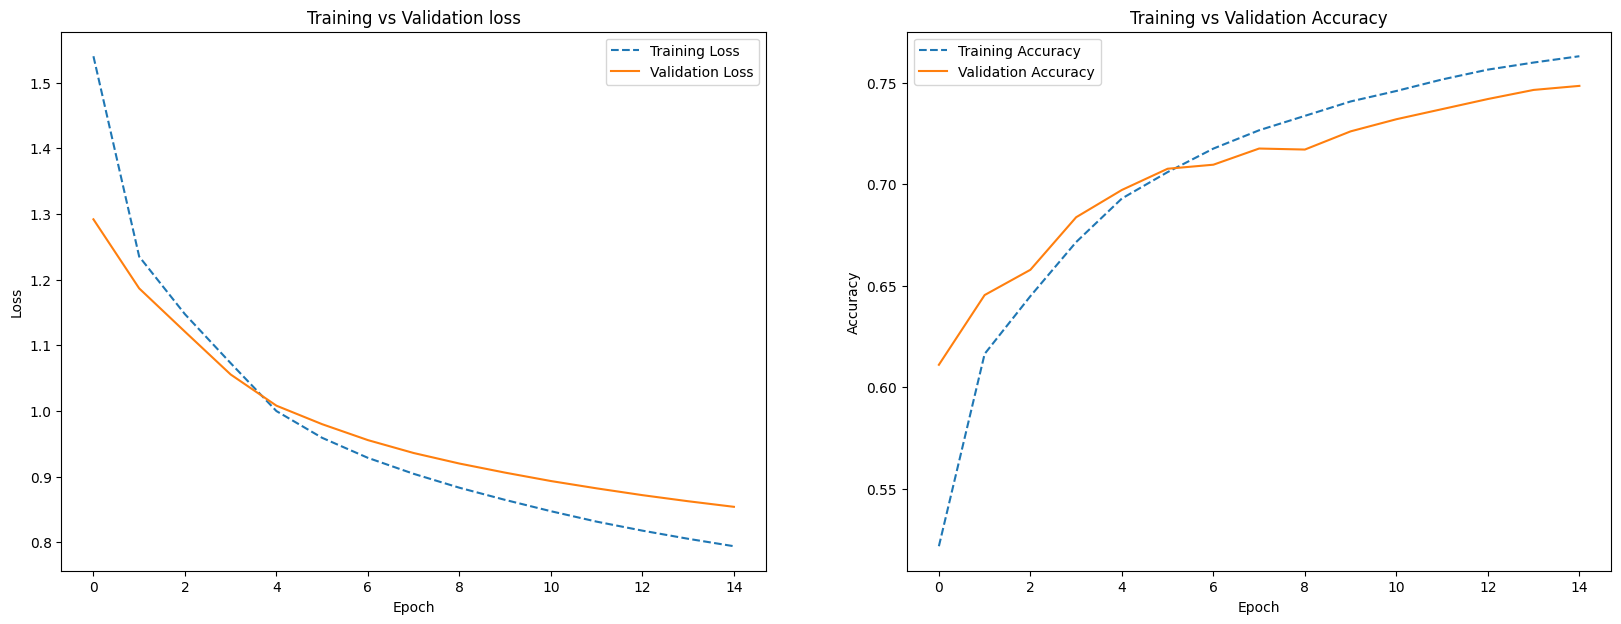

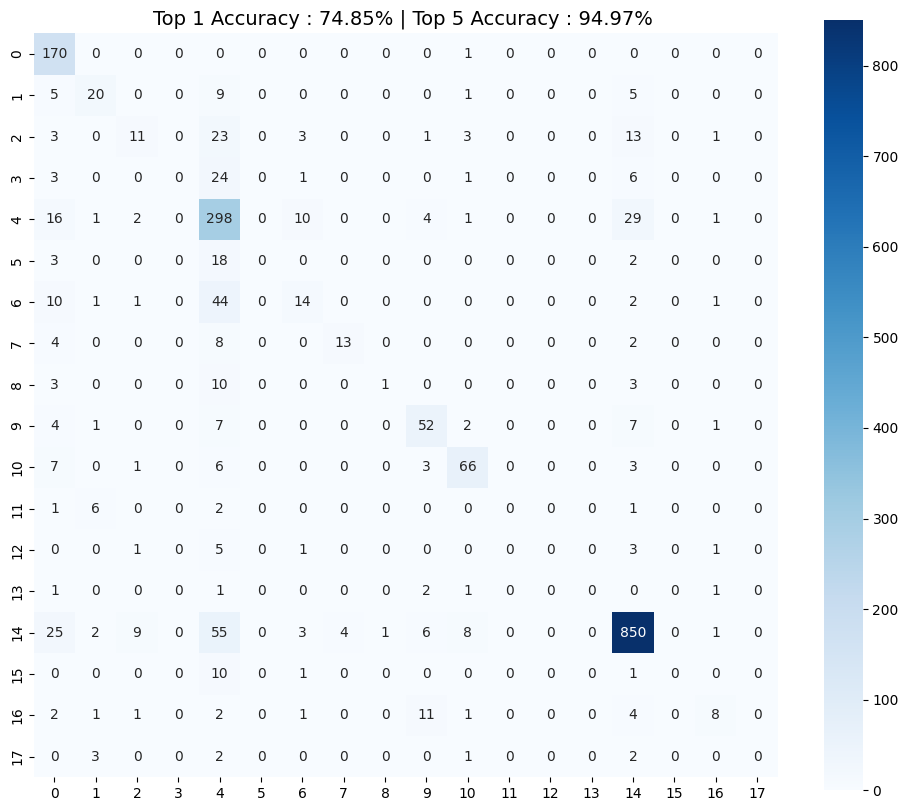

Top 1 Accuracy: 74.851%
Top 5 Accuracy: 94.97011952191235%
Classwise Accuracy Score: 
[0.99415205 0.5        0.18965517 0.         0.82320442 0.
 0.19178082 0.48148148 0.05882353 0.7027027  0.76744186 0.
 0.         0.         0.88174274 0.         0.25806452 0.        ]

	 With n_hidden=256 and n_linear=512 : 	 f1_score=0.719	 accuracy=0.749
Trying n_hidden=256 and n_linear=256 :

Epoch: 1 (1m 7s) 	Training Loss: 1.231, 	Test Loss: 1.074,  	Training acc: 0.64, 	Test acc: 0.69, 
Epoch: 2 (2m 13s) 	Training Loss: 0.985, 	Test Loss: 0.972,  	Training acc: 0.72, 	Test acc: 0.72, 
Epoch: 3 (3m 21s) 	Training Loss: 0.911, 	Test Loss: 0.929,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 4 (4m 27s) 	Training Loss: 0.869, 	Test Loss: 0.904,  	Training acc: 0.75, 	Test acc: 0.74, 
Epoch: 5 (5m 34s) 	Training Loss: 0.840, 	Test Loss: 0.886,  	Training acc: 0.75, 	Test acc: 0.74, 
Epoch: 6 (6m 40s) 	Training Loss: 0.819, 	Test Loss: 0.871,  	Training acc: 0.76, 	Test acc: 0.75, 
Epoch: 7 (7m 47s

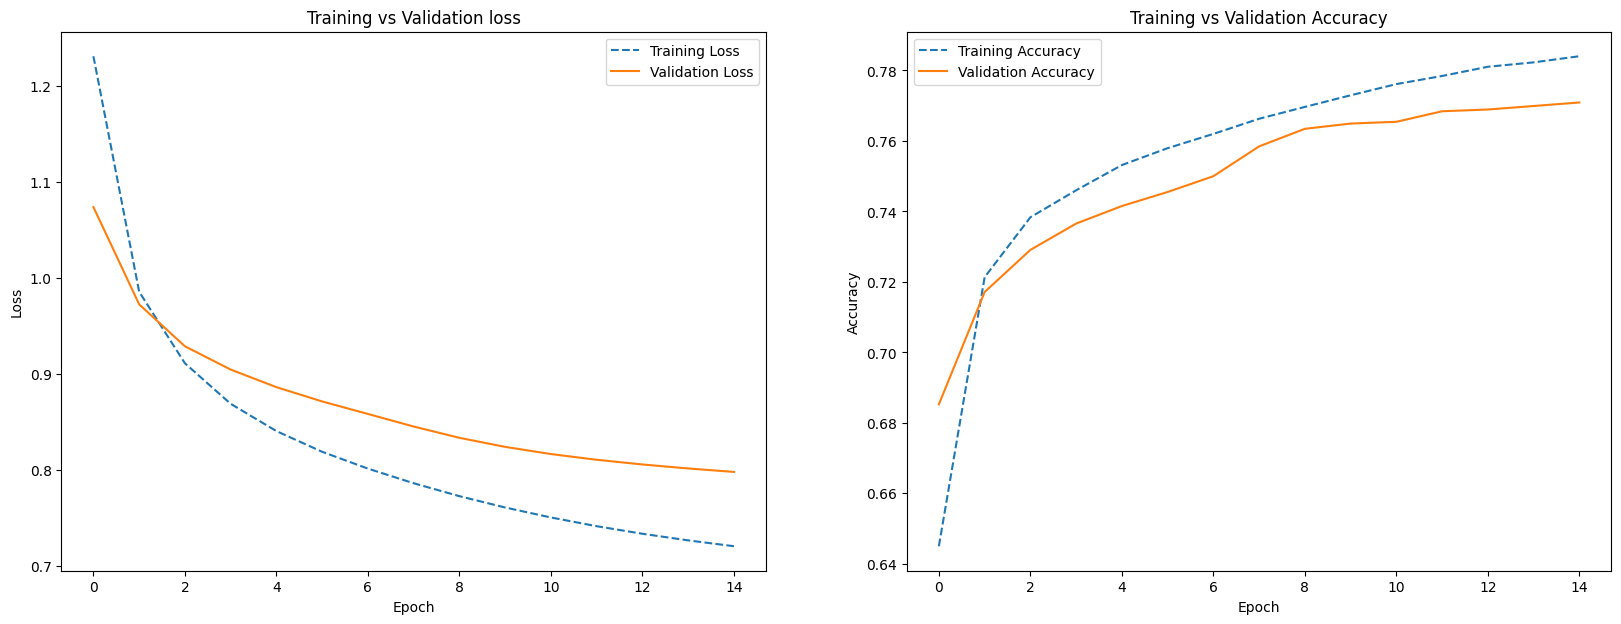

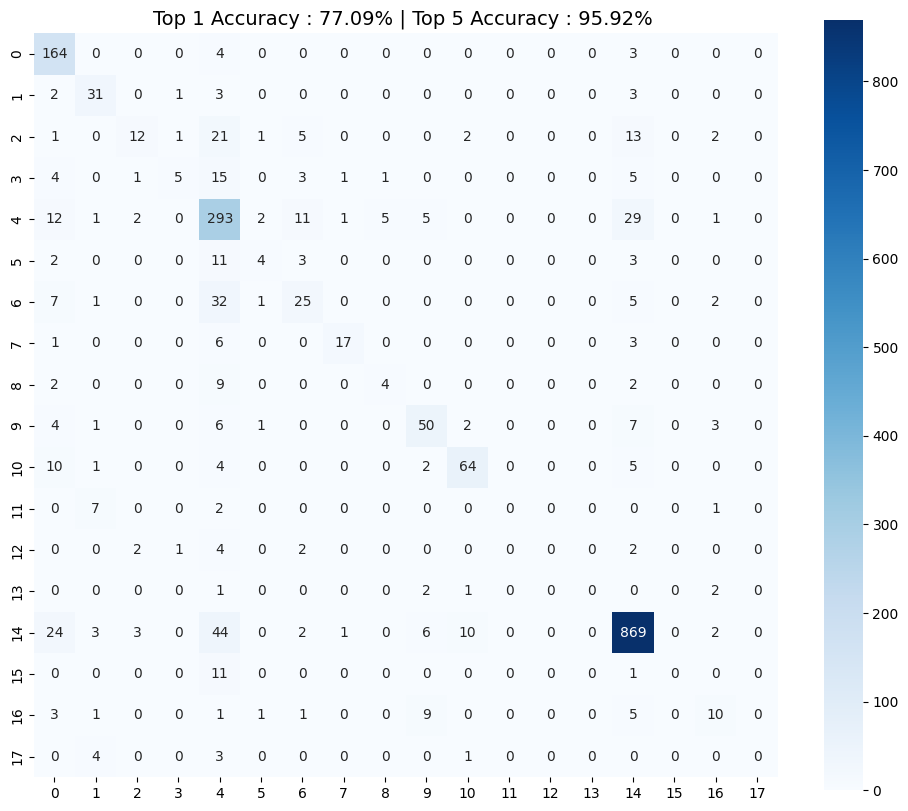

Top 1 Accuracy: 77.092%
Top 5 Accuracy: 95.91633466135458%
Classwise Accuracy Score: 
[0.95906433 0.775      0.20689655 0.14285714 0.80939227 0.17391304
 0.34246575 0.62962963 0.23529412 0.67567568 0.74418605 0.
 0.         0.         0.90145228 0.         0.32258065 0.        ]

	 With n_hidden=256 and n_linear=256 : 	 f1_score=0.750	 accuracy=0.771
Trying n_hidden=256 and n_linear=128 :

Epoch: 1 (0m 56s) 	Training Loss: 1.305, 	Test Loss: 1.148,  	Training acc: 0.62, 	Test acc: 0.66, 
Epoch: 2 (1m 52s) 	Training Loss: 1.065, 	Test Loss: 1.060,  	Training acc: 0.70, 	Test acc: 0.69, 
Epoch: 3 (2m 49s) 	Training Loss: 0.995, 	Test Loss: 1.010,  	Training acc: 0.72, 	Test acc: 0.70, 
Epoch: 4 (3m 45s) 	Training Loss: 0.949, 	Test Loss: 0.974,  	Training acc: 0.73, 	Test acc: 0.71, 
Epoch: 5 (4m 42s) 	Training Loss: 0.913, 	Test Loss: 0.947,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 6 (5m 37s) 	Training Loss: 0.885, 	Test Loss: 0.928,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 

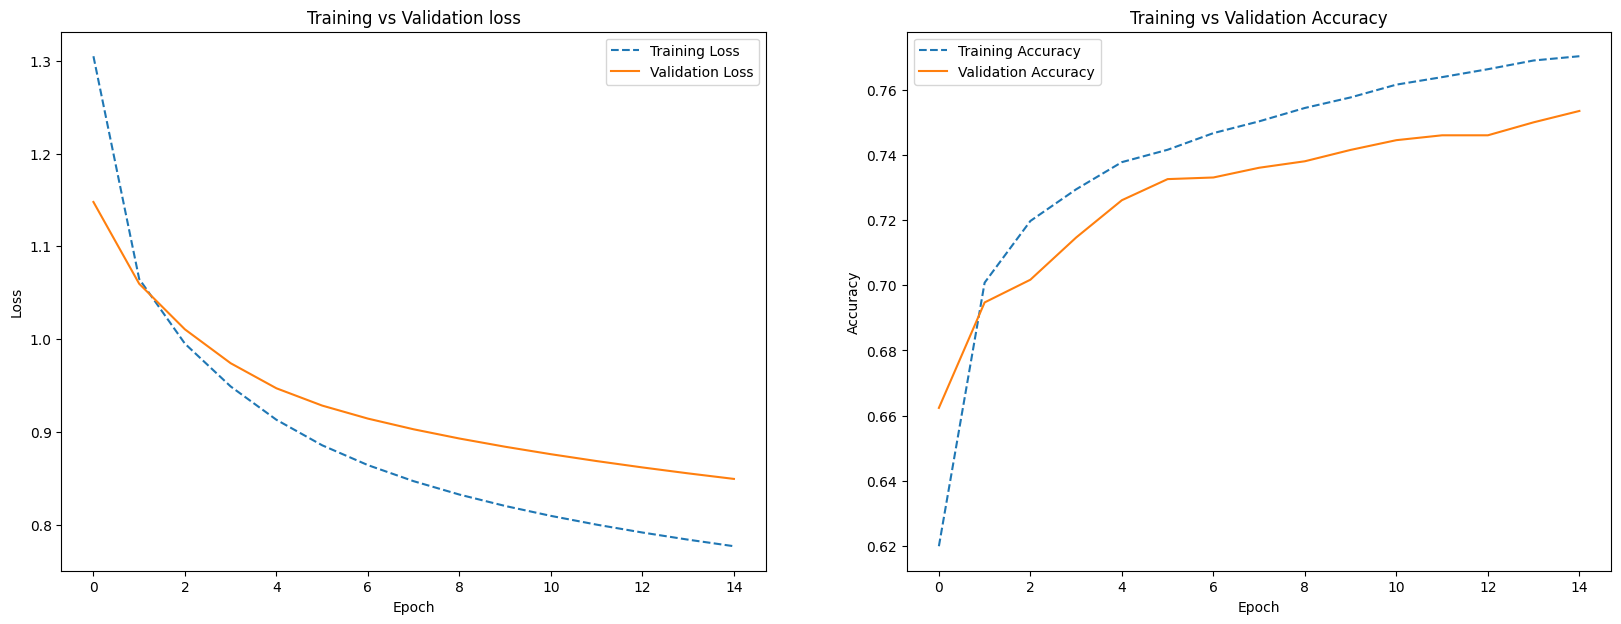

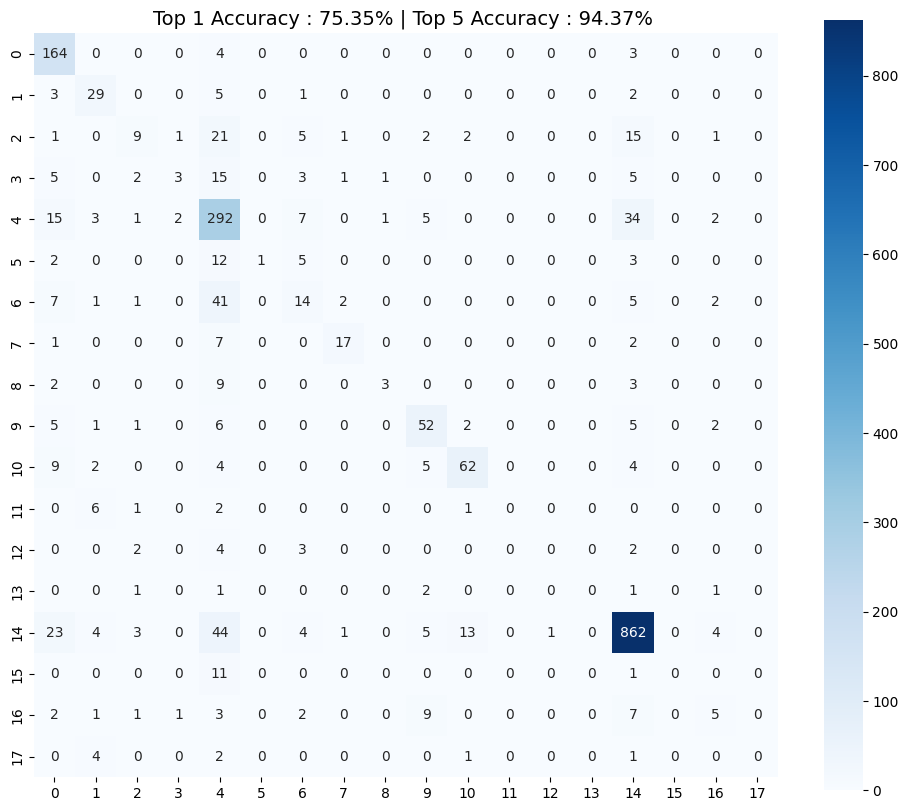

Top 1 Accuracy: 75.349%
Top 5 Accuracy: 94.37250996015936%
Classwise Accuracy Score: 
[0.95906433 0.725      0.15517241 0.08571429 0.80662983 0.04347826
 0.19178082 0.62962963 0.17647059 0.7027027  0.72093023 0.
 0.         0.         0.89419087 0.         0.16129032 0.        ]

	 With n_hidden=256 and n_linear=128 : 	 f1_score=0.727	 accuracy=0.753
Trying n_hidden=256 and n_linear=64 :

Epoch: 1 (0m 48s) 	Training Loss: 1.397, 	Test Loss: 1.237,  	Training acc: 0.60, 	Test acc: 0.64, 
Epoch: 2 (1m 38s) 	Training Loss: 1.151, 	Test Loss: 1.140,  	Training acc: 0.68, 	Test acc: 0.67, 
Epoch: 3 (2m 27s) 	Training Loss: 1.075, 	Test Loss: 1.089,  	Training acc: 0.70, 	Test acc: 0.69, 
Epoch: 4 (3m 17s) 	Training Loss: 1.027, 	Test Loss: 1.052,  	Training acc: 0.72, 	Test acc: 0.70, 
Epoch: 5 (4m 6s) 	Training Loss: 0.992, 	Test Loss: 1.025,  	Training acc: 0.73, 	Test acc: 0.71, 
Epoch: 6 (4m 55s) 	Training Loss: 0.967, 	Test Loss: 1.004,  	Training acc: 0.73, 	Test acc: 0.72, 
Epoch: 7 

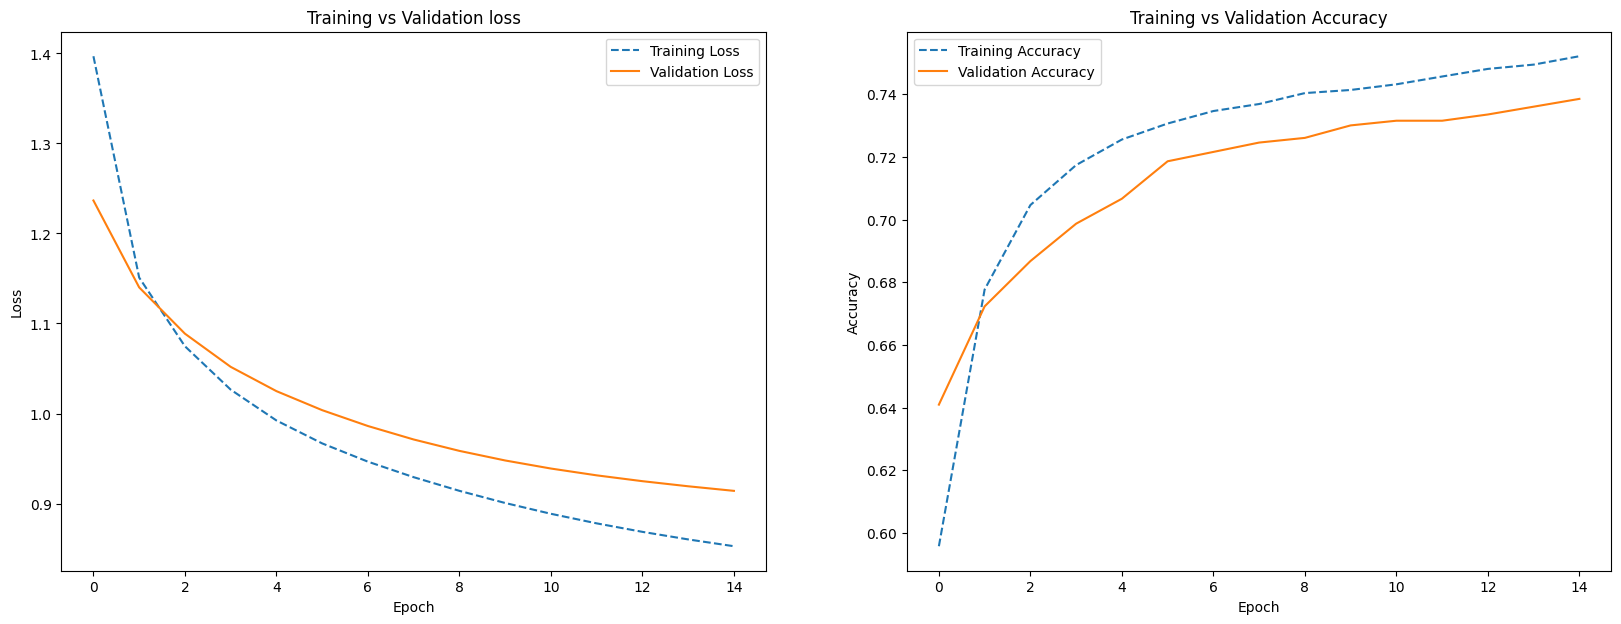

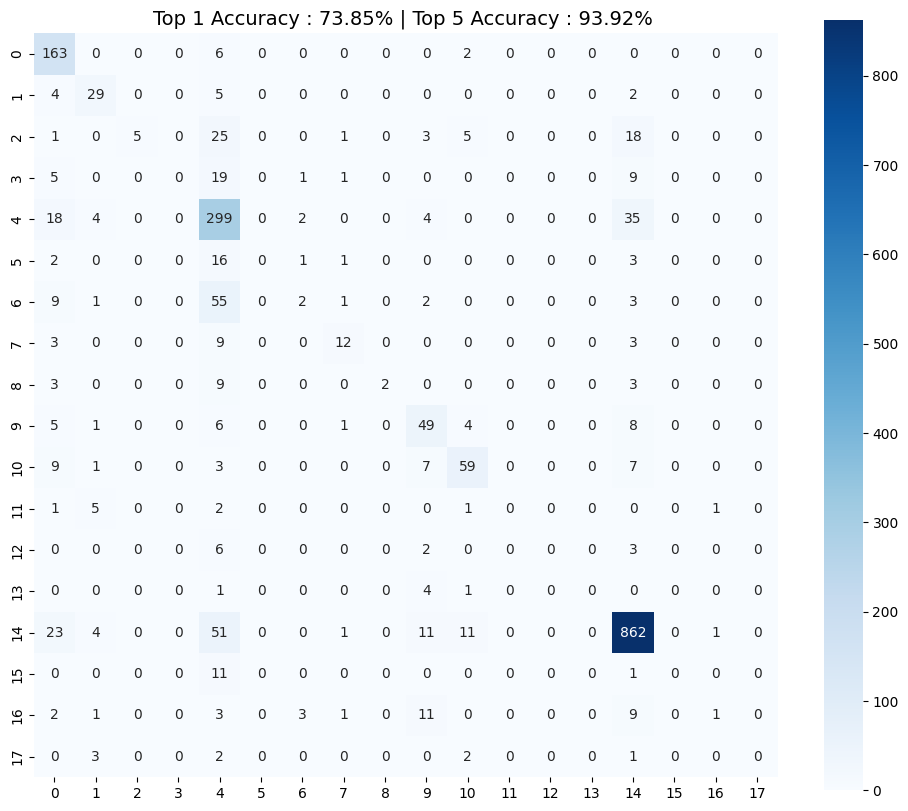

Top 1 Accuracy: 73.855%
Top 5 Accuracy: 93.92430278884463%
Classwise Accuracy Score: 
[0.95321637 0.725      0.0862069  0.         0.82596685 0.
 0.02739726 0.44444444 0.11764706 0.66216216 0.68604651 0.
 0.         0.         0.89419087 0.         0.03225806 0.        ]

	 With n_hidden=256 and n_linear=64 : 	 f1_score=0.696	 accuracy=0.739
Trying n_hidden=128 and n_linear=512 :

Epoch: 1 (1m 11s) 	Training Loss: 1.209, 	Test Loss: 1.028,  	Training acc: 0.64, 	Test acc: 0.69, 
Epoch: 2 (2m 22s) 	Training Loss: 0.952, 	Test Loss: 0.942,  	Training acc: 0.72, 	Test acc: 0.72, 
Epoch: 3 (3m 34s) 	Training Loss: 0.883, 	Test Loss: 0.897,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 4 (4m 45s) 	Training Loss: 0.840, 	Test Loss: 0.873,  	Training acc: 0.75, 	Test acc: 0.74, 
Epoch: 5 (5m 56s) 	Training Loss: 0.811, 	Test Loss: 0.855,  	Training acc: 0.76, 	Test acc: 0.74, 
Epoch: 6 (7m 7s) 	Training Loss: 0.788, 	Test Loss: 0.838,  	Training acc: 0.77, 	Test acc: 0.75, 
Epoch: 7 (8m 18s)

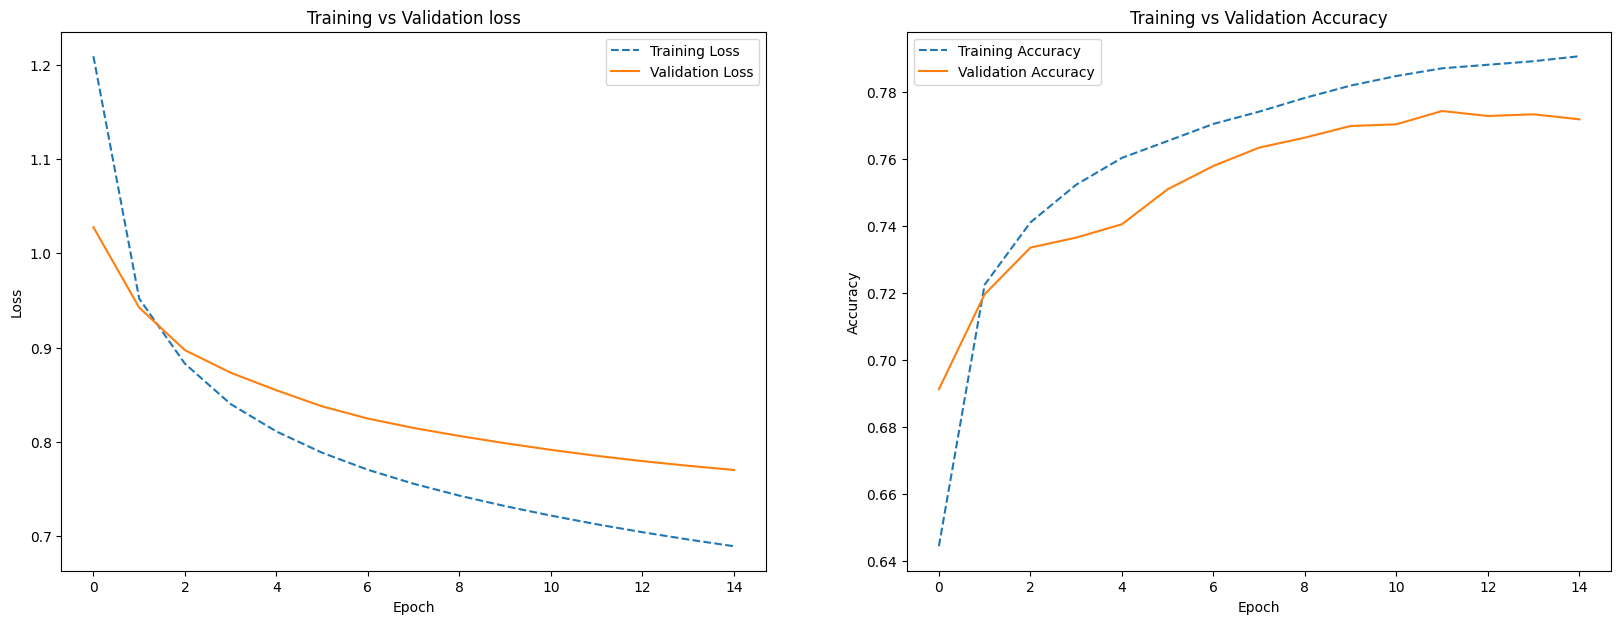

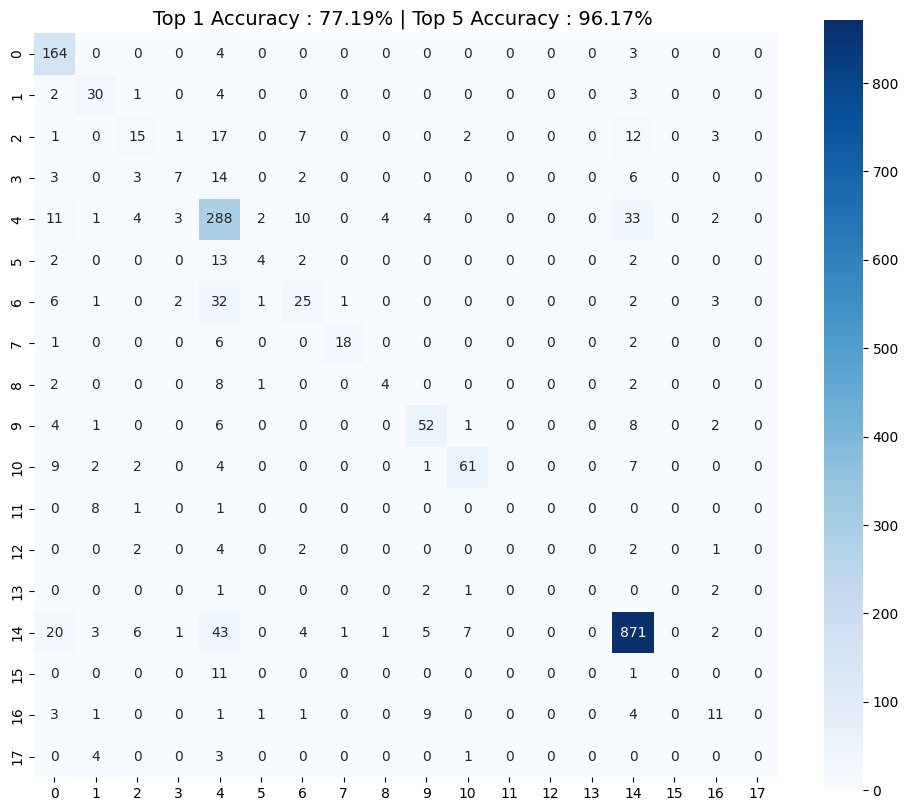

Top 1 Accuracy: 77.191%
Top 5 Accuracy: 96.16533864541833%
Classwise Accuracy Score: 
[0.95906433 0.75       0.25862069 0.2        0.79558011 0.17391304
 0.34246575 0.66666667 0.23529412 0.7027027  0.70930233 0.
 0.         0.         0.90352697 0.         0.35483871 0.        ]

	 With n_hidden=128 and n_linear=512 : 	 f1_score=0.754	 accuracy=0.772
Trying n_hidden=128 and n_linear=256 :

Epoch: 1 (0m 58s) 	Training Loss: 1.234, 	Test Loss: 1.078,  	Training acc: 0.64, 	Test acc: 0.68, 
Epoch: 2 (1m 57s) 	Training Loss: 1.000, 	Test Loss: 0.992,  	Training acc: 0.71, 	Test acc: 0.70, 
Epoch: 3 (2m 57s) 	Training Loss: 0.936, 	Test Loss: 0.945,  	Training acc: 0.73, 	Test acc: 0.72, 
Epoch: 4 (3m 56s) 	Training Loss: 0.894, 	Test Loss: 0.915,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 5 (4m 54s) 	Training Loss: 0.864, 	Test Loss: 0.896,  	Training acc: 0.75, 	Test acc: 0.74, 
Epoch: 6 (5m 52s) 	Training Loss: 0.842, 	Test Loss: 0.883,  	Training acc: 0.75, 	Test acc: 0.74, 
Epoch: 

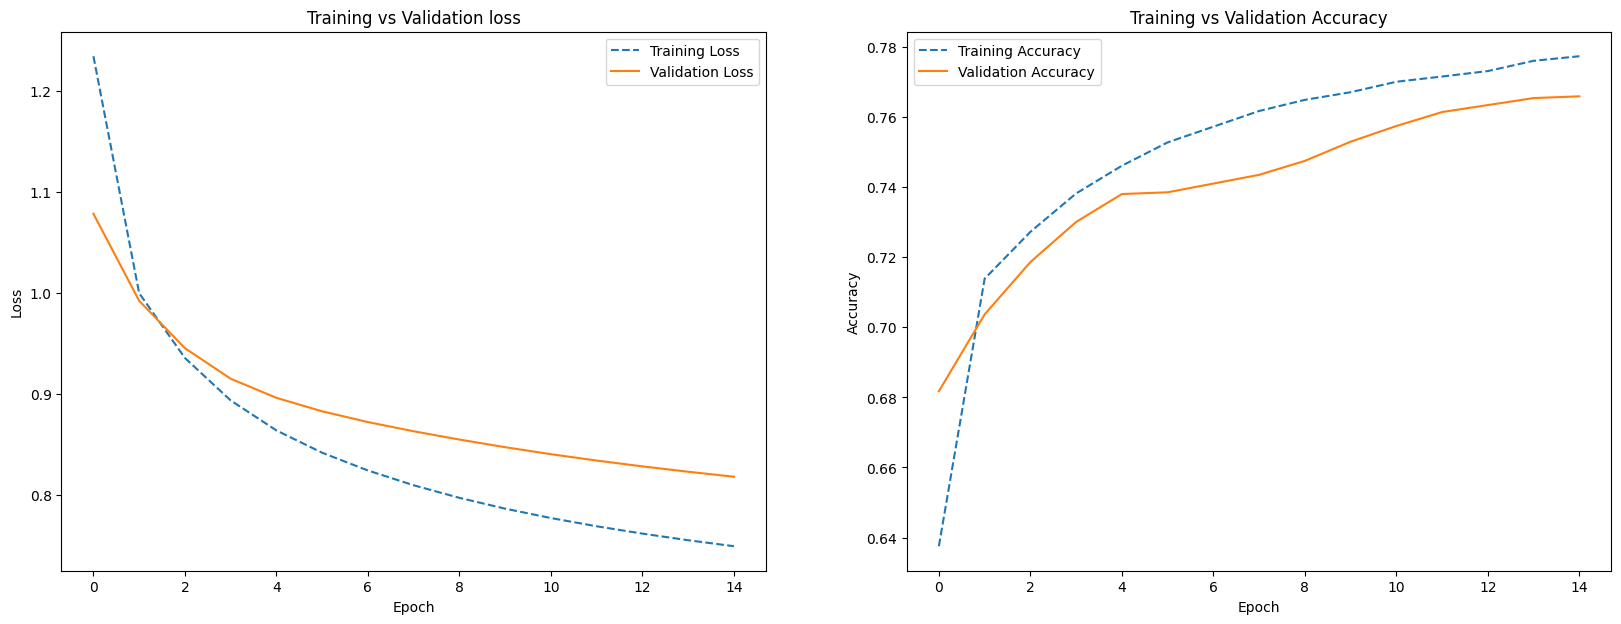

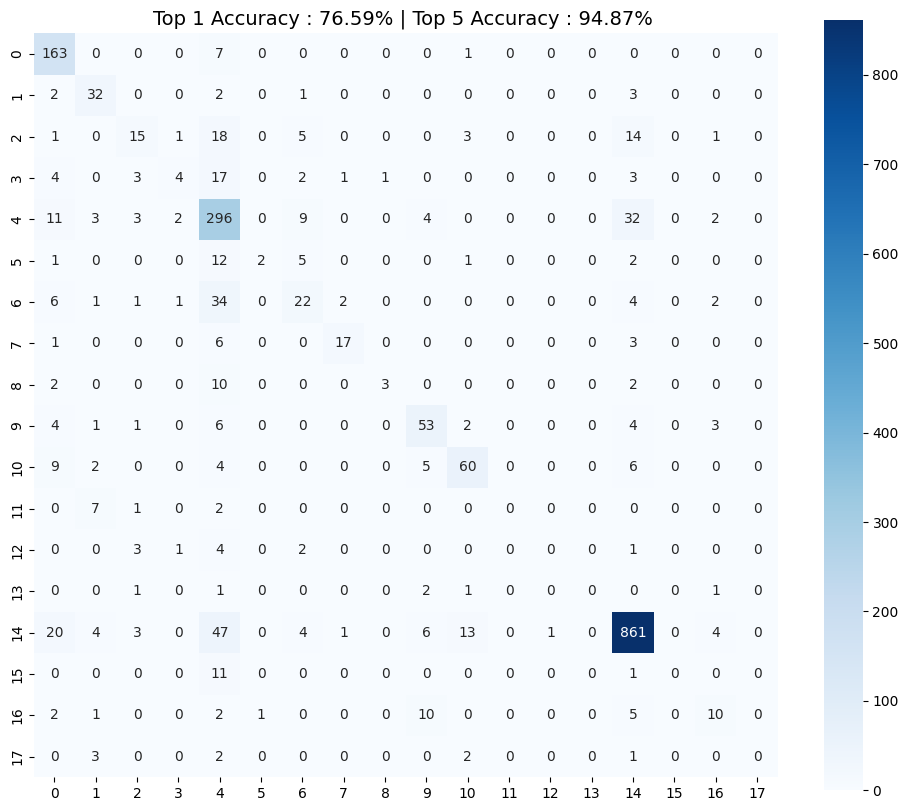

Top 1 Accuracy: 76.594%
Top 5 Accuracy: 94.87051792828686%
Classwise Accuracy Score: 
[0.95321637 0.8        0.25862069 0.11428571 0.81767956 0.08695652
 0.30136986 0.62962963 0.17647059 0.71621622 0.69767442 0.
 0.         0.         0.89315353 0.         0.32258065 0.        ]

	 With n_hidden=128 and n_linear=256 : 	 f1_score=0.745	 accuracy=0.766
Trying n_hidden=128 and n_linear=128 :

Epoch: 1 (0m 49s) 	Training Loss: 1.316, 	Test Loss: 1.174,  	Training acc: 0.62, 	Test acc: 0.66, 
Epoch: 2 (1m 40s) 	Training Loss: 1.083, 	Test Loss: 1.085,  	Training acc: 0.70, 	Test acc: 0.69, 
Epoch: 3 (2m 30s) 	Training Loss: 1.016, 	Test Loss: 1.035,  	Training acc: 0.71, 	Test acc: 0.70, 
Epoch: 4 (3m 22s) 	Training Loss: 0.977, 	Test Loss: 1.002,  	Training acc: 0.72, 	Test acc: 0.71, 
Epoch: 5 (4m 12s) 	Training Loss: 0.950, 	Test Loss: 0.978,  	Training acc: 0.73, 	Test acc: 0.71, 
Epoch: 6 (5m 2s) 	Training Loss: 0.929, 	Test Loss: 0.960,  	Training acc: 0.73, 	Test acc: 0.72, 
Epoch: 7

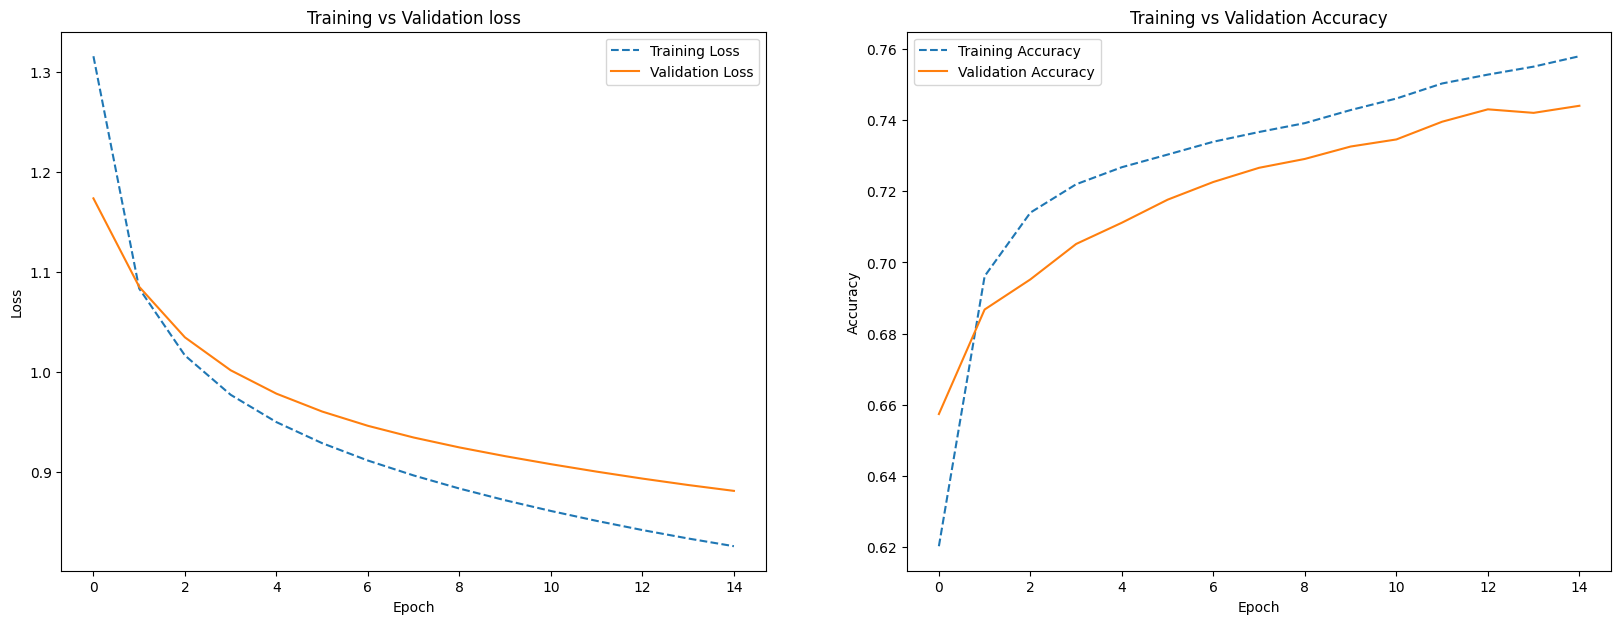

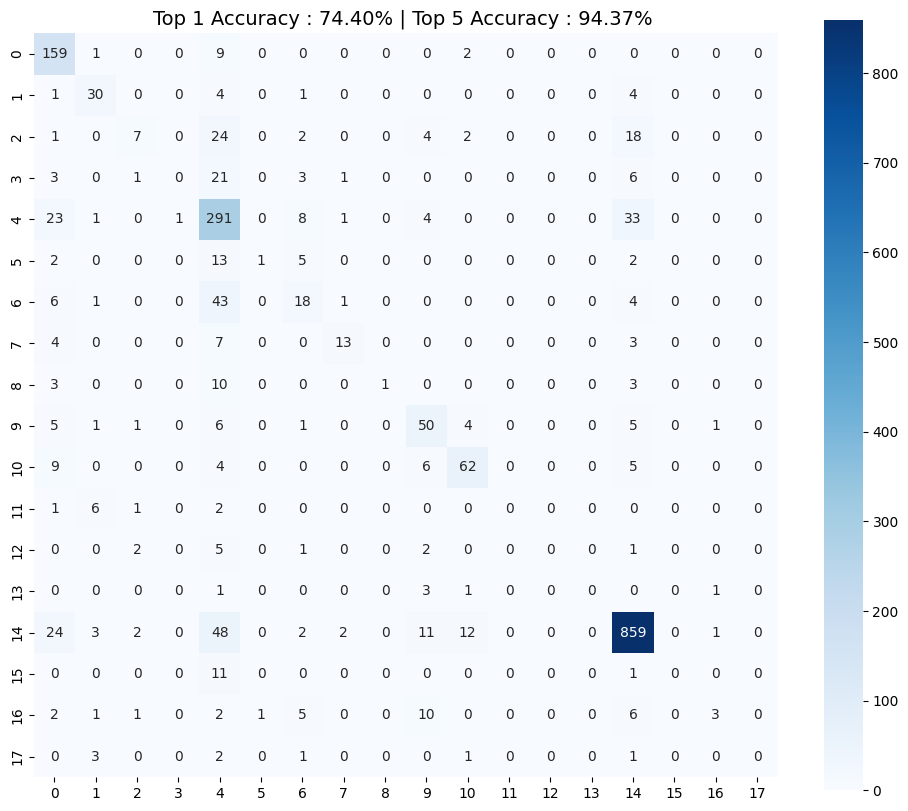

Top 1 Accuracy: 74.402%
Top 5 Accuracy: 94.37250996015936%
Classwise Accuracy Score: 
[0.92982456 0.75       0.12068966 0.         0.8038674  0.04347826
 0.24657534 0.48148148 0.05882353 0.67567568 0.72093023 0.
 0.         0.         0.89107884 0.         0.09677419 0.        ]

	 With n_hidden=128 and n_linear=128 : 	 f1_score=0.713	 accuracy=0.744
Trying n_hidden=128 and n_linear=64 :

Epoch: 1 (0m 43s) 	Training Loss: 1.448, 	Test Loss: 1.340,  	Training acc: 0.57, 	Test acc: 0.61, 
Epoch: 2 (1m 27s) 	Training Loss: 1.224, 	Test Loss: 1.188,  	Training acc: 0.65, 	Test acc: 0.66, 
Epoch: 3 (2m 10s) 	Training Loss: 1.118, 	Test Loss: 1.127,  	Training acc: 0.68, 	Test acc: 0.68, 
Epoch: 4 (2m 53s) 	Training Loss: 1.070, 	Test Loss: 1.089,  	Training acc: 0.70, 	Test acc: 0.69, 
Epoch: 5 (3m 36s) 	Training Loss: 1.036, 	Test Loss: 1.060,  	Training acc: 0.71, 	Test acc: 0.70, 
Epoch: 6 (4m 19s) 	Training Loss: 1.010, 	Test Loss: 1.037,  	Training acc: 0.72, 	Test acc: 0.70, 
Epoch: 7

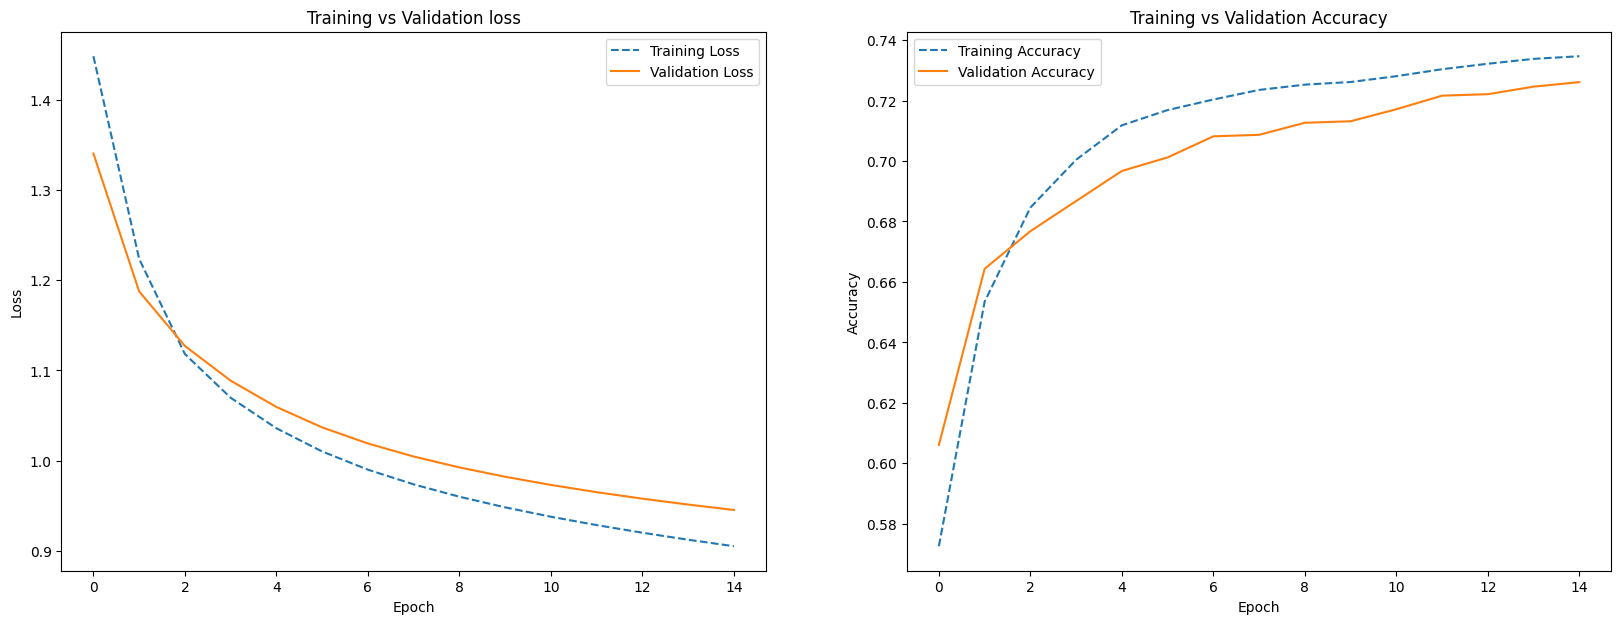

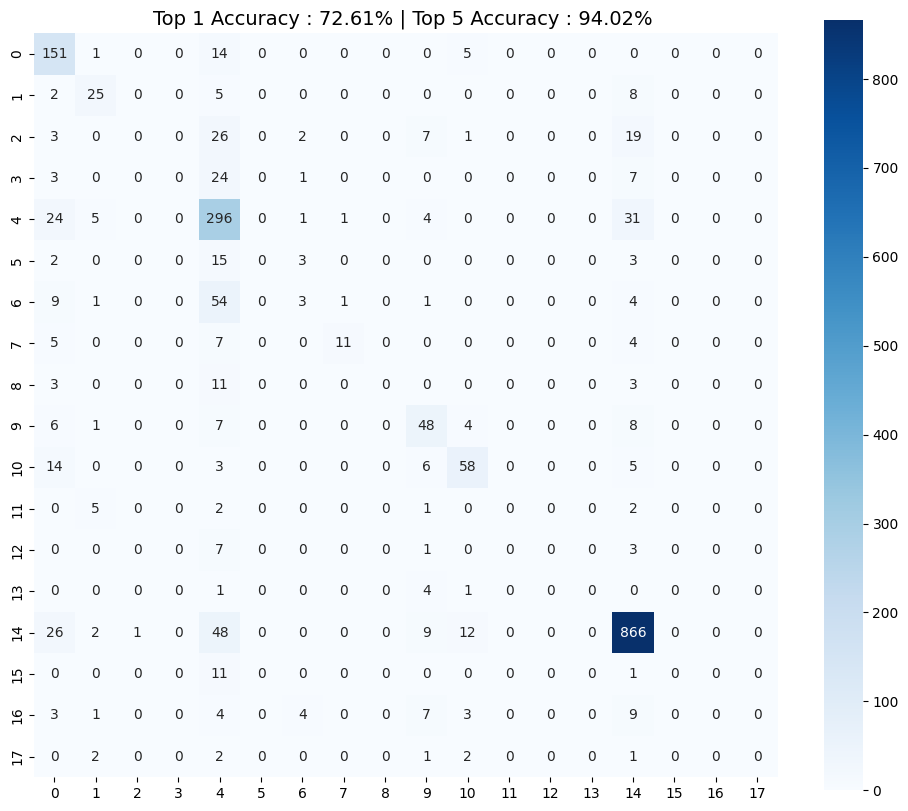

Top 1 Accuracy: 72.610%
Top 5 Accuracy: 94.02390438247012%
Classwise Accuracy Score: 
[0.88304094 0.625      0.         0.         0.81767956 0.
 0.04109589 0.40740741 0.         0.64864865 0.6744186  0.
 0.         0.         0.89834025 0.         0.         0.        ]

	 With n_hidden=128 and n_linear=64 : 	 f1_score=0.681	 accuracy=0.726
Trying n_hidden=64 and n_linear=512 :

Epoch: 1 (1m 3s) 	Training Loss: 1.156, 	Test Loss: 1.025,  	Training acc: 0.66, 	Test acc: 0.69, 
Epoch: 2 (2m 7s) 	Training Loss: 0.950, 	Test Loss: 0.956,  	Training acc: 0.72, 	Test acc: 0.71, 
Epoch: 3 (3m 11s) 	Training Loss: 0.897, 	Test Loss: 0.916,  	Training acc: 0.73, 	Test acc: 0.73, 
Epoch: 4 (4m 14s) 	Training Loss: 0.863, 	Test Loss: 0.889,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 5 (5m 18s) 	Training Loss: 0.838, 	Test Loss: 0.870,  	Training acc: 0.75, 	Test acc: 0.74, 
Epoch: 6 (6m 22s) 	Training Loss: 0.816, 	Test Loss: 0.853,  	Training acc: 0.76, 	Test acc: 0.75, 
Epoch: 7 (7m 25s) 	

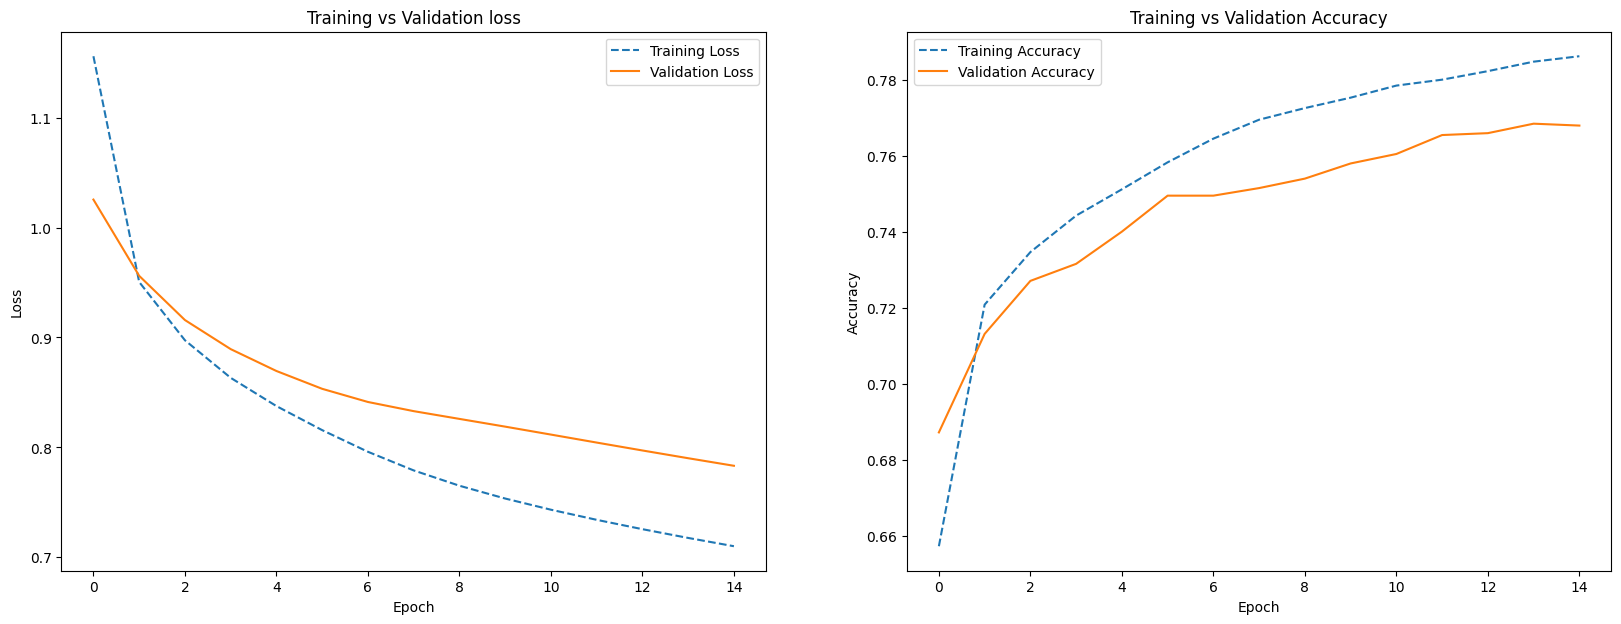

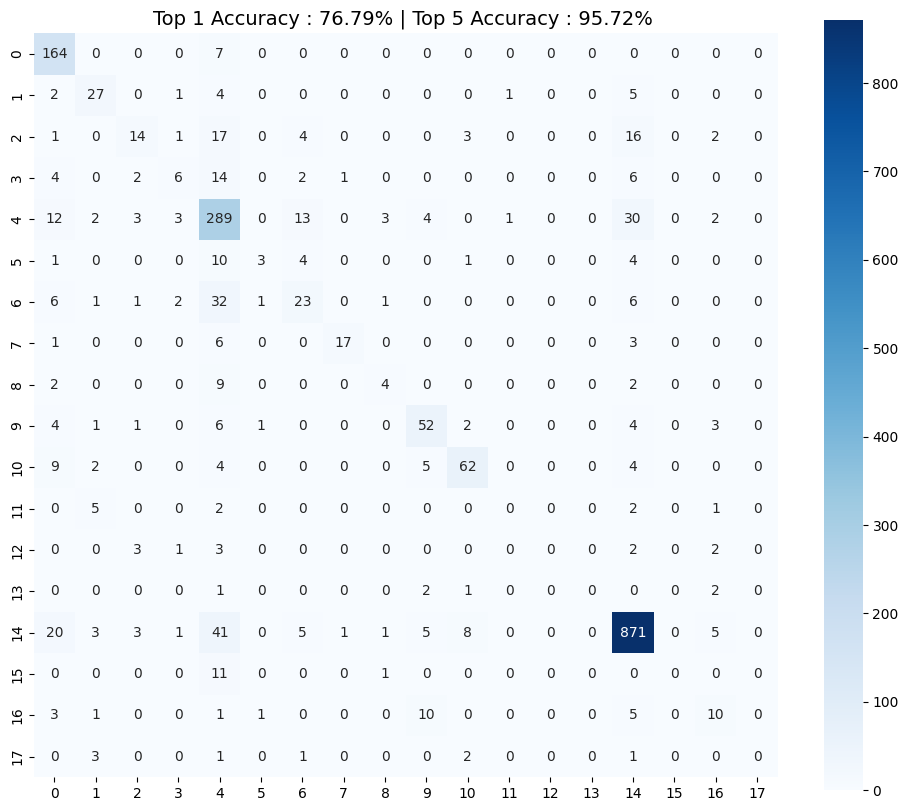

Top 1 Accuracy: 76.793%
Top 5 Accuracy: 95.7171314741036%
Classwise Accuracy Score: 
[0.95906433 0.675      0.24137931 0.17142857 0.79834254 0.13043478
 0.31506849 0.62962963 0.23529412 0.7027027  0.72093023 0.
 0.         0.         0.90352697 0.         0.32258065 0.        ]

	 With n_hidden=64 and n_linear=512 : 	 f1_score=0.749	 accuracy=0.768
Trying n_hidden=64 and n_linear=256 :

Epoch: 1 (0m 51s) 	Training Loss: 1.211, 	Test Loss: 1.080,  	Training acc: 0.65, 	Test acc: 0.69, 
Epoch: 2 (1m 42s) 	Training Loss: 0.997, 	Test Loss: 0.999,  	Training acc: 0.71, 	Test acc: 0.70, 
Epoch: 3 (2m 34s) 	Training Loss: 0.942, 	Test Loss: 0.959,  	Training acc: 0.73, 	Test acc: 0.71, 
Epoch: 4 (3m 25s) 	Training Loss: 0.911, 	Test Loss: 0.934,  	Training acc: 0.73, 	Test acc: 0.72, 
Epoch: 5 (4m 17s) 	Training Loss: 0.888, 	Test Loss: 0.915,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 6 (5m 8s) 	Training Loss: 0.870, 	Test Loss: 0.900,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 7 (6

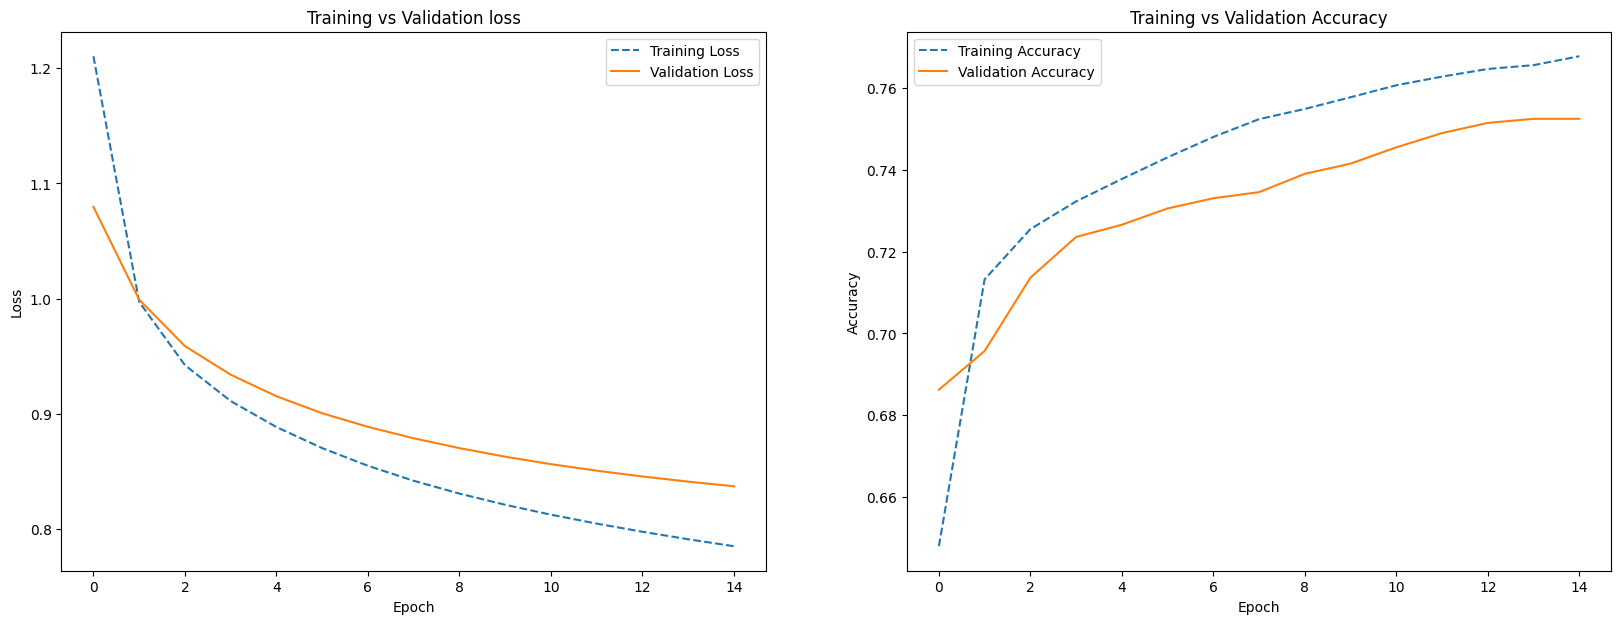

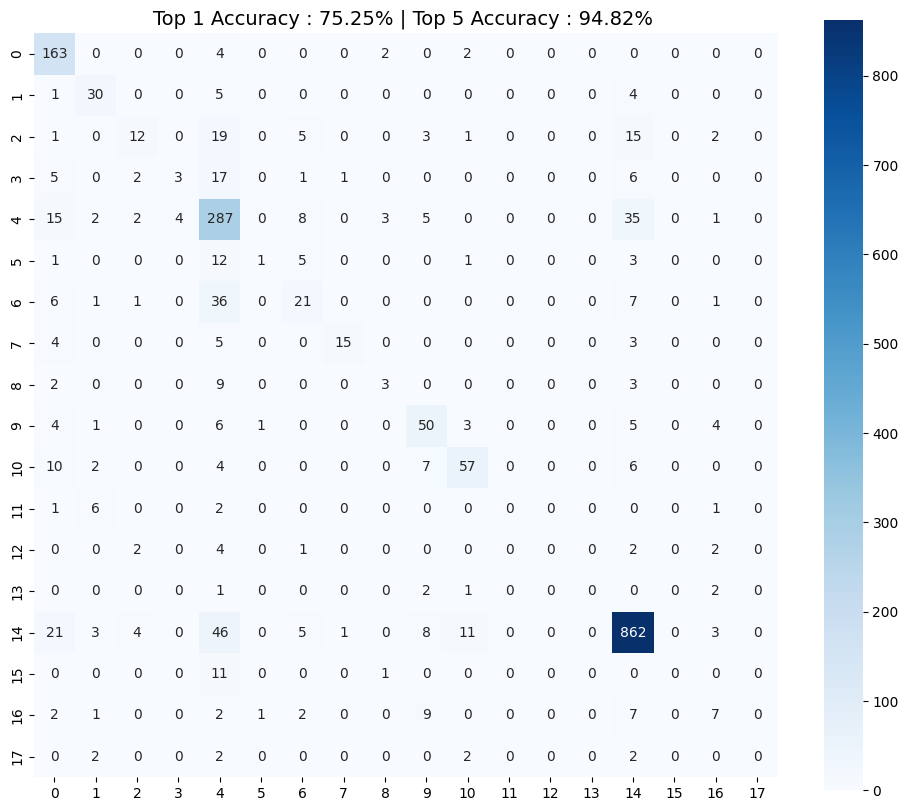

Top 1 Accuracy: 75.249%
Top 5 Accuracy: 94.82071713147411%
Classwise Accuracy Score: 
[0.95321637 0.75       0.20689655 0.08571429 0.79281768 0.04347826
 0.28767123 0.55555556 0.17647059 0.67567568 0.6627907  0.
 0.         0.         0.89419087 0.         0.22580645 0.        ]

	 With n_hidden=64 and n_linear=256 : 	 f1_score=0.729	 accuracy=0.752
Trying n_hidden=64 and n_linear=128 :

Epoch: 1 (0m 44s) 	Training Loss: 1.345, 	Test Loss: 1.200,  	Training acc: 0.61, 	Test acc: 0.65, 
Epoch: 2 (1m 28s) 	Training Loss: 1.101, 	Test Loss: 1.103,  	Training acc: 0.69, 	Test acc: 0.69, 
Epoch: 3 (2m 15s) 	Training Loss: 1.037, 	Test Loss: 1.063,  	Training acc: 0.71, 	Test acc: 0.69, 
Epoch: 4 (3m 2s) 	Training Loss: 1.001, 	Test Loss: 1.033,  	Training acc: 0.71, 	Test acc: 0.70, 
Epoch: 5 (3m 46s) 	Training Loss: 0.974, 	Test Loss: 1.009,  	Training acc: 0.72, 	Test acc: 0.71, 
Epoch: 6 (4m 33s) 	Training Loss: 0.953, 	Test Loss: 0.988,  	Training acc: 0.72, 	Test acc: 0.71, 
Epoch: 7 (

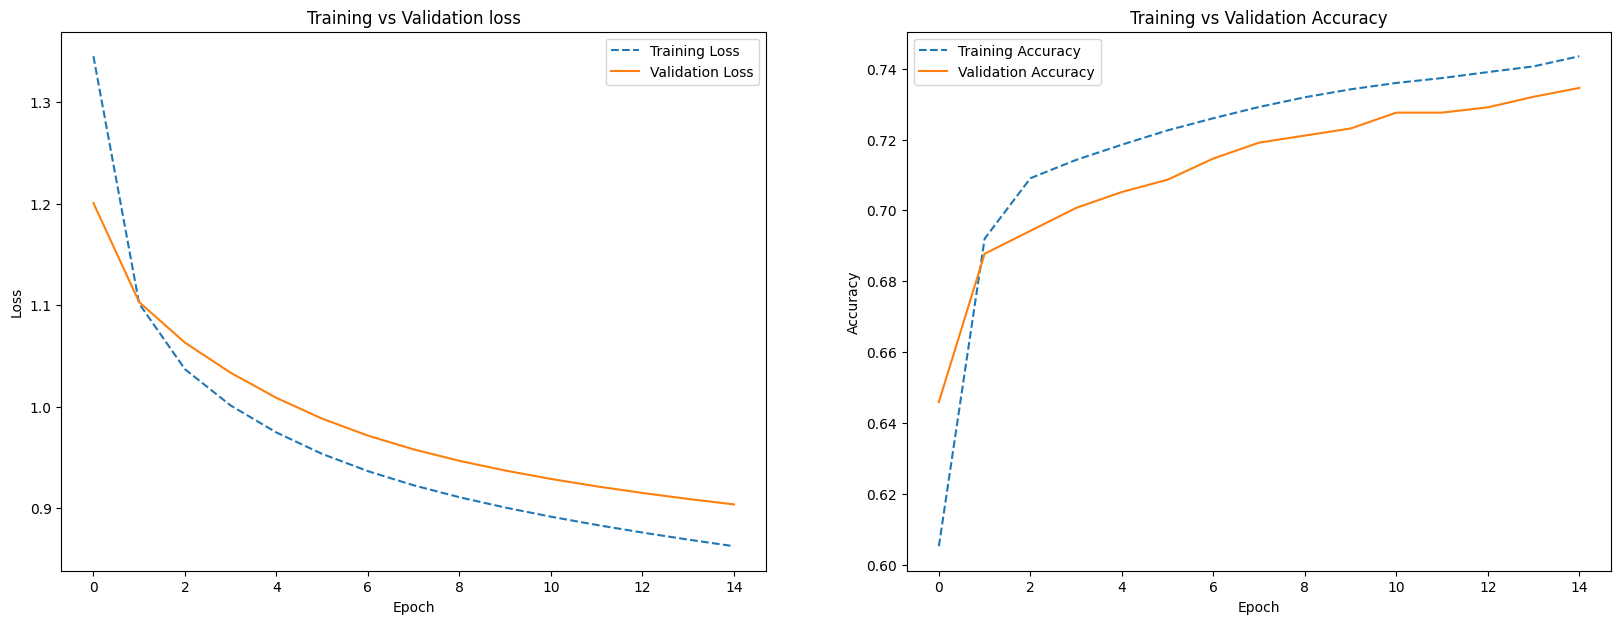

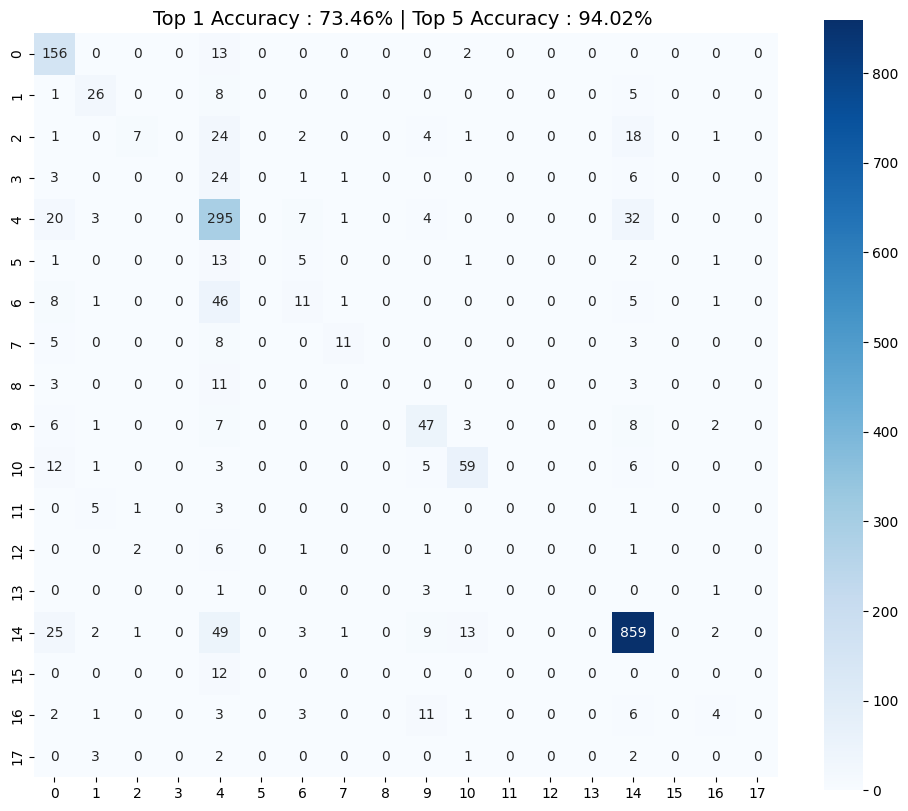

Top 1 Accuracy: 73.456%
Top 5 Accuracy: 94.02390438247012%
Classwise Accuracy Score: 
[0.9122807  0.65       0.12068966 0.         0.81491713 0.
 0.15068493 0.40740741 0.         0.63513514 0.68604651 0.
 0.         0.         0.89107884 0.         0.12903226 0.        ]

	 With n_hidden=64 and n_linear=128 : 	 f1_score=0.701	 accuracy=0.735
Trying n_hidden=64 and n_linear=64 :

Epoch: 1 (0m 38s) 	Training Loss: 1.441, 	Test Loss: 1.345,  	Training acc: 0.57, 	Test acc: 0.59, 
Epoch: 2 (1m 16s) 	Training Loss: 1.262, 	Test Loss: 1.238,  	Training acc: 0.63, 	Test acc: 0.64, 
Epoch: 3 (1m 53s) 	Training Loss: 1.148, 	Test Loss: 1.153,  	Training acc: 0.67, 	Test acc: 0.67, 
Epoch: 4 (2m 31s) 	Training Loss: 1.089, 	Test Loss: 1.116,  	Training acc: 0.69, 	Test acc: 0.69, 
Epoch: 5 (3m 9s) 	Training Loss: 1.058, 	Test Loss: 1.093,  	Training acc: 0.70, 	Test acc: 0.69, 
Epoch: 6 (3m 47s) 	Training Loss: 1.036, 	Test Loss: 1.075,  	Training acc: 0.70, 	Test acc: 0.70, 
Epoch: 7 (4m 25s) 	

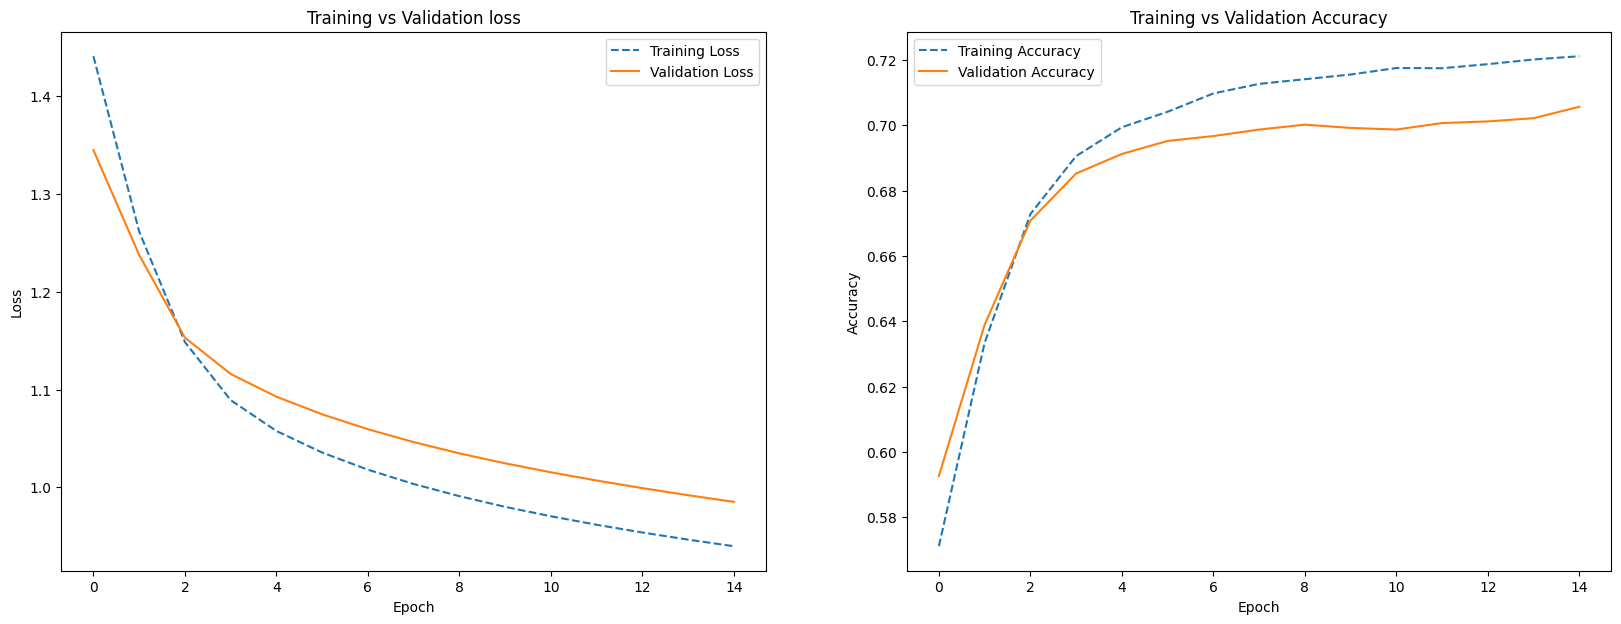

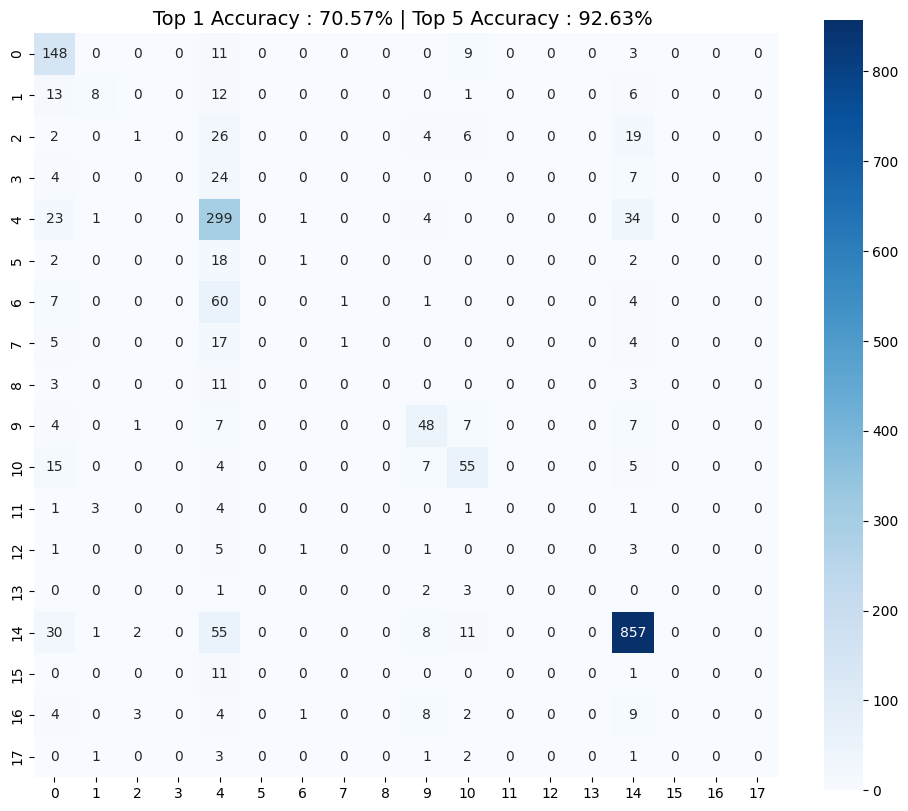

Top 1 Accuracy: 70.568%
Top 5 Accuracy: 92.62948207171314%
Classwise Accuracy Score: 
[0.86549708 0.2        0.01724138 0.         0.82596685 0.
 0.         0.03703704 0.         0.64864865 0.63953488 0.
 0.         0.         0.88900415 0.         0.         0.        ]

	 With n_hidden=64 and n_linear=64 : 	 f1_score=0.656	 accuracy=0.706

Best model = RNN(
  (i2lh): Linear(in_features=185, out_features=512, bias=True)
  (l2h): Linear(in_features=512, out_features=128, bias=True)
  (i2lo): Linear(in_features=185, out_features=512, bias=True)
  (l2o): Linear(in_features=512, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
  (tanh): Tanh()
)	 with f1 score = 0.7540723725536111



In [260]:
criterion = nn.NLLLoss()
learning_rate = 0.005

hidden_sizes = [512, 256, 128, 64]
linear_sizes = [512, 256, 128, 64]

best_score = 0.0
best_model = None
for n_hidden in hidden_sizes:
      for n_linear in linear_sizes:
        print(f'Trying n_hidden={n_hidden} and n_linear={n_linear} :\n')
        rnn = RNN(n_letters, n_hidden,n_linear, n_categories)
        optimizer = torch.optim.Adagrad(rnn.parameters(),lr= learning_rate)
        loss_list = model_training(rnn,criterion,optimizer,x_train,y_train,x_test,y_test,num_epochs=15)
        plot_training_graphs(loss_list)
        with torch.no_grad(): 
                test_output =[]
                for i,line_tensor in enumerate(x_test):  
                        test_output.append(rnn.evaluate(line_tensor))
                np_y_test = list_to_nparray(y_test)
                np_test_output = list_to_nparray(test_output)
                
                confusionMatrixAndAccuracyReport(np_y_test,np_test_output,all_categories)
                Y_pred = np_test_output.argmax(axis=1)
                score = metrics.f1_score(np_y_test,Y_pred,average='weighted')
                print(f'\n\t With n_hidden={n_hidden} and n_linear={n_linear} : \t f1_score={score:.3f}\t accuracy={metrics.accuracy_score(np_y_test,Y_pred):.3f}')
                if score > best_score:
                      best_score = score
                      best_model = rnn

print(f'\nBest model = {best_model}\t with f1 score = {best_score}\n')

Epoch: 1 (1m 1s) 	Training Loss: 0.953, 	Test Loss: 0.929,  	Training acc: 0.72, 	Test acc: 0.72, 
Epoch: 2 (1m 57s) 	Training Loss: 0.875, 	Test Loss: 0.900,  	Training acc: 0.74, 	Test acc: 0.74, 
Epoch: 3 (2m 47s) 	Training Loss: 0.848, 	Test Loss: 0.886,  	Training acc: 0.75, 	Test acc: 0.74, 
Epoch: 4 (3m 32s) 	Training Loss: 0.830, 	Test Loss: 0.876,  	Training acc: 0.76, 	Test acc: 0.75, 
Epoch: 5 (4m 18s) 	Training Loss: 0.817, 	Test Loss: 0.868,  	Training acc: 0.76, 	Test acc: 0.75, 
Epoch: 6 (5m 4s) 	Training Loss: 0.806, 	Test Loss: 0.861,  	Training acc: 0.76, 	Test acc: 0.75, 
Epoch: 7 (5m 49s) 	Training Loss: 0.797, 	Test Loss: 0.855,  	Training acc: 0.77, 	Test acc: 0.75, 
Epoch: 8 (6m 38s) 	Training Loss: 0.789, 	Test Loss: 0.850,  	Training acc: 0.77, 	Test acc: 0.75, 
Epoch: 9 (7m 24s) 	Training Loss: 0.782, 	Test Loss: 0.845,  	Training acc: 0.77, 	Test acc: 0.76, 
Epoch: 10 (8m 23s) 	Training Loss: 0.776, 	Test Loss: 0.841,  	Training acc: 0.77, 	Test acc: 0.76, 
T

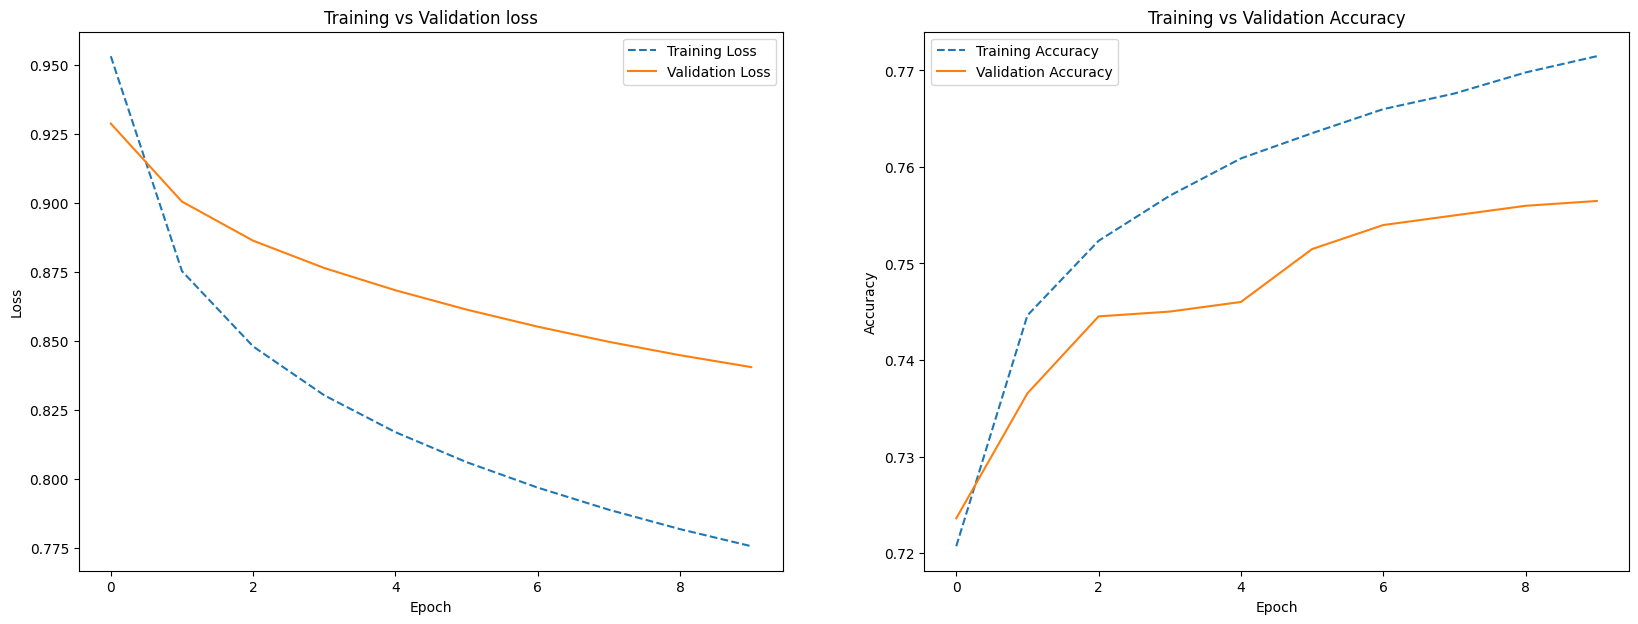

In [248]:
optimizer = torch.optim.Adagrad(best_model.parameters(),lr= learning_rate)
loss_list = model_training(best_model,criterion,optimizer,x_train,y_train,x_test,y_test,num_epochs=10)
plot_training_graphs(loss_list)

## 3. Obtain a Confusion Matrix on validation data for your best model. [2]

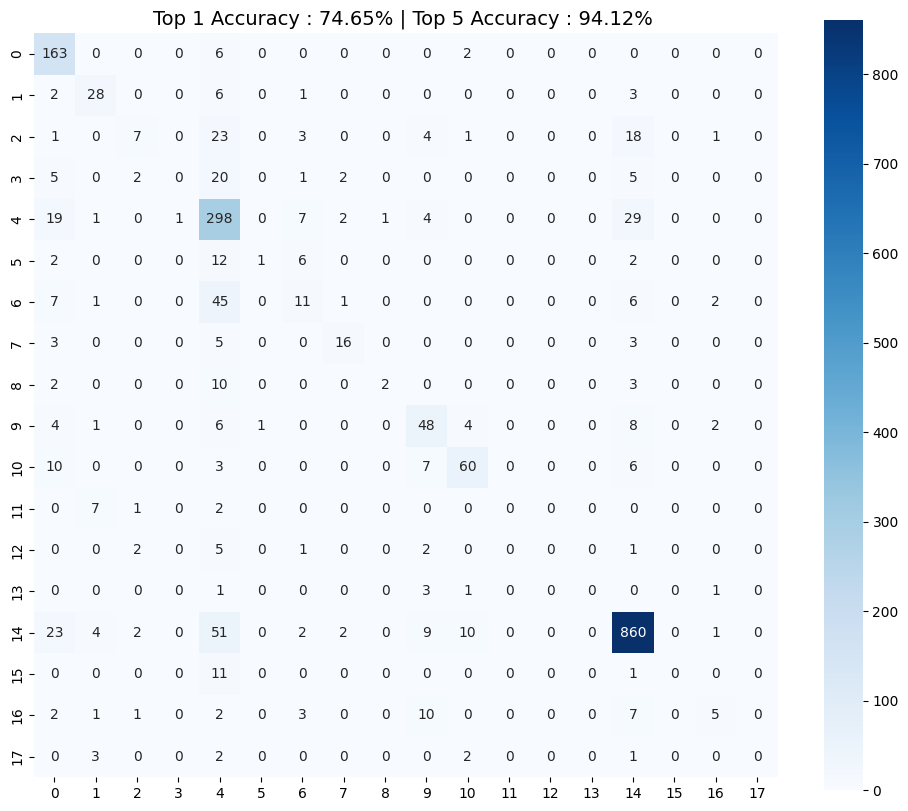

Top 1 Accuracy: 74.651%
Top 5 Accuracy: 94.12350597609563%
Classwise Accuracy Score: 
[0.95321637 0.7        0.12068966 0.         0.82320442 0.04347826
 0.15068493 0.59259259 0.11764706 0.64864865 0.69767442 0.
 0.         0.         0.89211618 0.         0.16129032 0.        ]


In [257]:
with torch.no_grad(): 

    test_output =[]
    for i,line_tensor in enumerate(x_test):  
            test_output.append(best_model.evaluate(line_tensor))

    confusionMatrixAndAccuracyReport(list_to_nparray(y_test),list_to_nparray(test_output),all_categories)

## 4. Add three more linear layers to our current RNN architecture and perform 2 & 3 again.[4]

In [215]:
import torch.nn as nn

class RNNExtended(nn.Module):
    def __init__(self, input_size, hidden_size, linear_size, output_size):
        super(RNNExtended, self).__init__()

        self.hidden_size = hidden_size
        self.linear_size = linear_size

        self.i2lh = nn.Linear(input_size + hidden_size, linear_size)
        
        # New three layers
        self.lh1 = nn.Linear(linear_size, linear_size)
        self.lh2 = nn.Linear(linear_size, linear_size)
        self.lh3 = nn.Linear(linear_size, linear_size)

        self.l2h = nn.Linear(linear_size, hidden_size)


        self.i2lo = nn.Linear(input_size + hidden_size, linear_size)
        
        # New three layers
        self.lo1 = nn.Linear(linear_size, linear_size)
        self.lo2 = nn.Linear(linear_size, linear_size)
        self.lo3 = nn.Linear(linear_size, linear_size)

        self.l2o = nn.Linear(linear_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)
        self.tanh = nn.Tanh()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2lh(combined)
        hidden = self.tanh(hidden)
         # New three layers
        hidden = self.lh1(hidden)
        hidden = self.tanh(hidden)
        hidden = self.lh1(hidden)
        hidden = self.tanh(hidden)
        hidden = self.lh1(hidden)
        hidden = self.tanh(hidden)

        hidden = self.l2h(hidden)
        hidden = self.tanh(hidden)

        output = self.i2lo(combined)
        output = self.tanh(output)
        # New three layers
        output = self.lo1(combined)
        output = self.tanh(output)
        output = self.lo2(combined)
        output = self.tanh(output)
        output = self.lo3(combined)
        output = self.tanh(output)

        output = self.l2o(output)
        output = self.softmax(output)

        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def evaluate(self,line_tensor):
        hidden = self.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden = self(line_tensor[i], hidden)

        return output

    def predict(self,input_line, n_predictions=3):
        print('\n> %s' % input_line)
        with torch.no_grad():
            output = self.evaluate(lineToTensor(input_line))

            # Get top N categories
            topv, topi = output.topk(n_predictions, 1, True)
            predictions = []

            for i in range(n_predictions):
                value = topv[0][i].item()
                category_index = topi[0][i].item()
                print('(%.2f) %s' % (value, all_categories[category_index]))
                predictions.append([value, all_categories[category_index]])

Epoch: 1 (0m 45s) 	Training Loss: 1.316, 	Test Loss: 1.167,  	Training acc: 0.62, 	Test acc: 0.66, 
Epoch: 2 (1m 30s) 	Training Loss: 1.077, 	Test Loss: 1.071,  	Training acc: 0.70, 	Test acc: 0.69, 
Epoch: 3 (2m 13s) 	Training Loss: 1.010, 	Test Loss: 1.024,  	Training acc: 0.72, 	Test acc: 0.70, 
Epoch: 4 (2m 57s) 	Training Loss: 0.972, 	Test Loss: 0.994,  	Training acc: 0.73, 	Test acc: 0.71, 
Epoch: 5 (3m 41s) 	Training Loss: 0.945, 	Test Loss: 0.973,  	Training acc: 0.73, 	Test acc: 0.72, 
Epoch: 6 (4m 24s) 	Training Loss: 0.924, 	Test Loss: 0.955,  	Training acc: 0.73, 	Test acc: 0.72, 
Epoch: 7 (5m 8s) 	Training Loss: 0.906, 	Test Loss: 0.940,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 8 (6m 4s) 	Training Loss: 0.890, 	Test Loss: 0.928,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 9 (7m 31s) 	Training Loss: 0.877, 	Test Loss: 0.918,  	Training acc: 0.74, 	Test acc: 0.73, 
Epoch: 10 (8m 57s) 	Training Loss: 0.865, 	Test Loss: 0.909,  	Training acc: 0.75, 	Test acc: 0.73, 
T

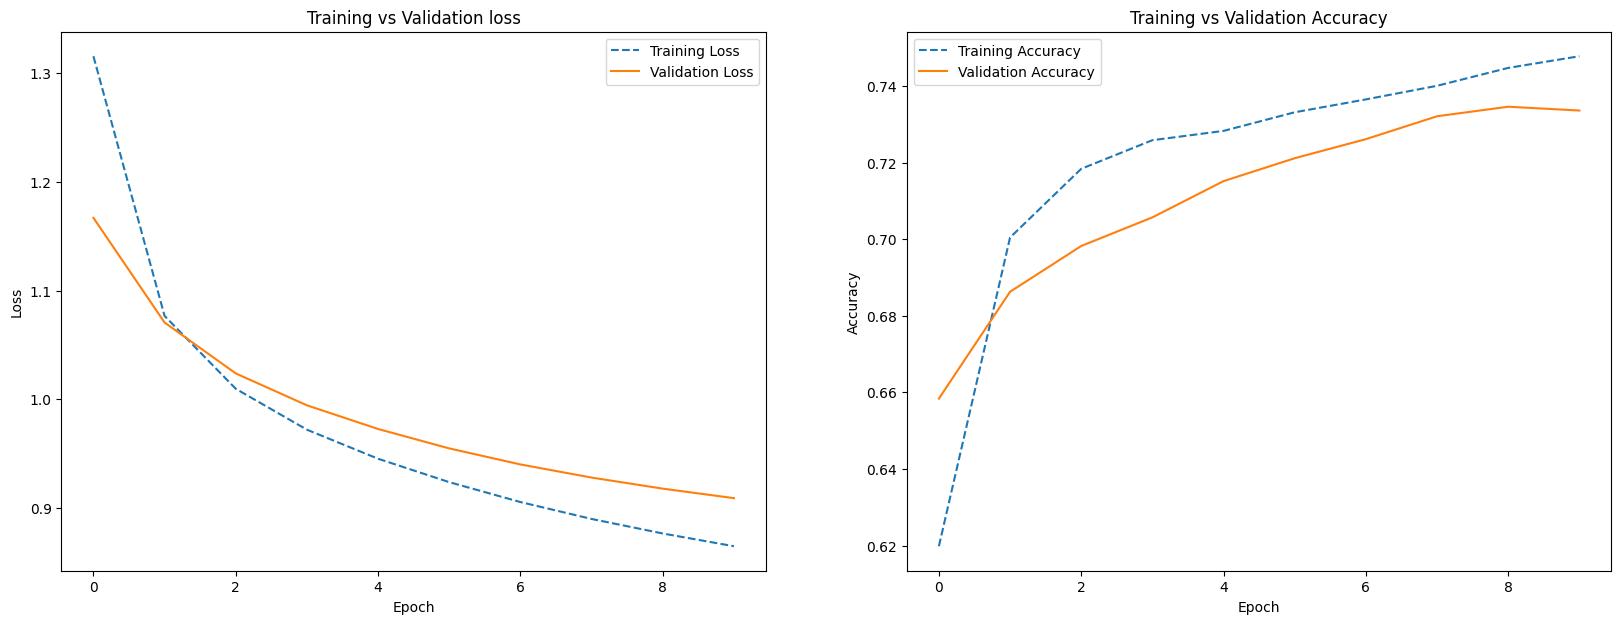

In [250]:
criterion = nn.NLLLoss()
learning_rate = 0.005
n_hidden = 128
n_linear = 128
rnn_x = RNNExtended(n_letters, n_hidden,n_linear, n_categories)
optimizer = torch.optim.Adagrad(rnn_x.parameters(),lr= learning_rate)
loss_list = model_training(rnn_x,criterion,optimizer,x_train,y_train,x_test,y_test,num_epochs=10)
plot_training_graphs(loss_list)


## 5. Report test accuracy for both the above architectures.

RNN Model First One


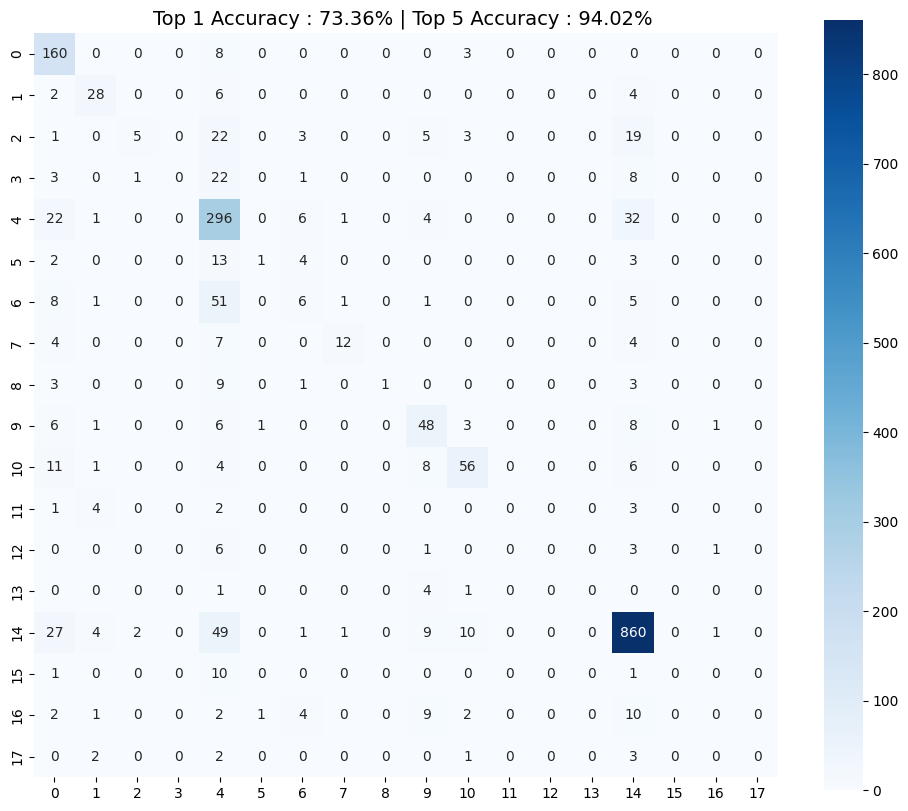

Top 1 Accuracy: 73.357%
Top 5 Accuracy: 94.02390438247012%
Classwise Accuracy Score: 
[0.93567251 0.7        0.0862069  0.         0.81767956 0.04347826
 0.08219178 0.44444444 0.05882353 0.64864865 0.65116279 0.
 0.         0.         0.89211618 0.         0.         0.        ]
RNN Model with extra three linear LAYER


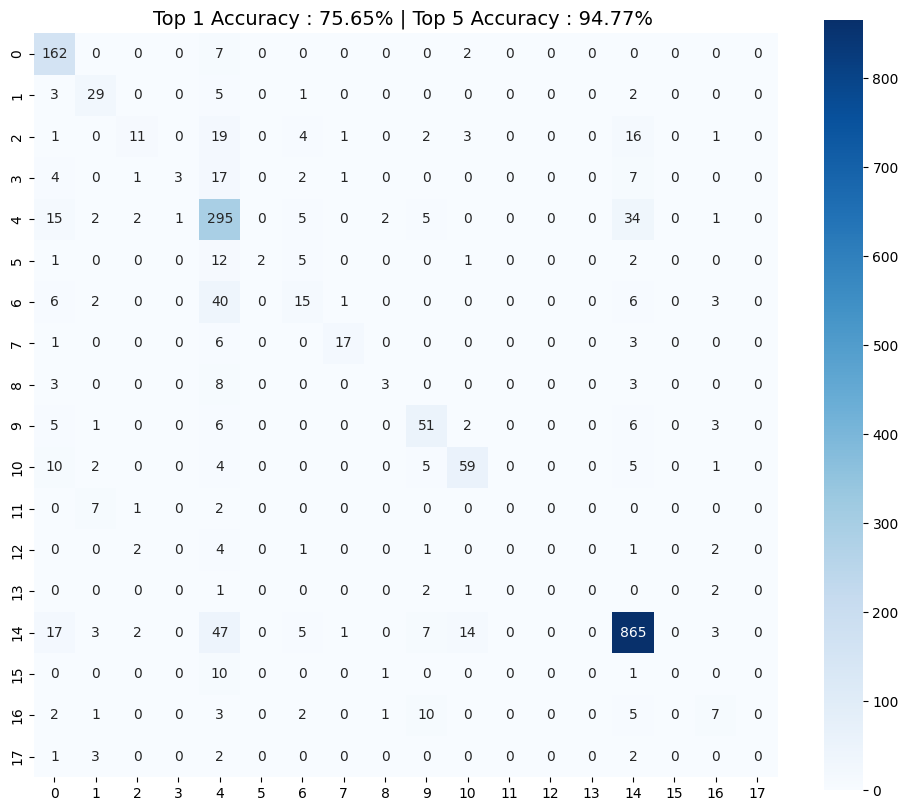

Top 1 Accuracy: 75.647%
Top 5 Accuracy: 94.77091633466136%
Classwise Accuracy Score: 
[0.94736842 0.725      0.18965517 0.08571429 0.81491713 0.08695652
 0.20547945 0.62962963 0.17647059 0.68918919 0.68604651 0.
 0.         0.         0.8973029  0.         0.22580645 0.        ]


In [252]:

with torch.no_grad():
       
        print('RNN Model First One')
        test_output =[]
        for i,line_tensor in enumerate(x_test):  
                test_output.append(rnn_x.evaluate(line_tensor))

        confusionMatrixAndAccuracyReport(list_to_nparray(y_test),list_to_nparray(test_output),all_categories)


        print('RNN Model with extra three linear LAYER')

        test_output =[]
        for i,line_tensor in enumerate(x_test):  
                test_output.append(best_model.evaluate(line_tensor))

        confusionMatrixAndAccuracyReport(list_to_nparray(y_test),list_to_nparray(test_output),all_categories)

## 6.1 Build a stacked RNN (2 RNN blocks) model and do appropriate hyperparameter tuning.

In [253]:
import torch.nn as nn

class RNNStacked(nn.Module):
    def __init__(self, input_size, hidden_size, linear_size, output_size):
        super(RNNExtended, self).__init__()

        self.hidden_size = hidden_size
        self.linear_size = linear_size

        self.rnn1 = RNN(n_letters, n_hidden,n_linear, n_categories)
        self.rnn2 = RNN(n_letters, n_hidden,n_linear, n_categories)

    def forward(self, input, hidden):
        output, hidden = self.rnn1(input, hidden)
        output, hidden = self.rnn1(input, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def evaluate(self,line_tensor):
        hidden1 = self.initHidden()
        hidden2 = self.initHidden()
        for i in range(line_tensor.size()[0]):
            output, hidden1 = self(line_tensor[i], hidden1)
            output, hidden2 = self(output, hidden2)

        return output

    def predict(self,input_line, n_predictions=3):
        print('\n> %s' % input_line)
        with torch.no_grad():
            output = self.evaluate(lineToTensor(input_line))

            # Get top N categories
            topv, topi = output.topk(n_predictions, 1, True)
            predictions = []

            for i in range(n_predictions):
                value = topv[0][i].item()
                category_index = topi[0][i].item()
                print('(%.2f) %s' % (value, all_categories[category_index]))
                predictions.append([value, all_categories[category_index]])

In [254]:
# Train the model
def stacked_model_training(rnn_stacked,criterion,optimizer,x_train,y_train,x_val,y_val,num_epochs = 10):
    start = time.time()
    loss_list = []
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_acc = 0.0
        val_acc = 0.0
        for i,line_tensor in enumerate(x_train):
            category_tensor =y_train[i]
            hidden1 = rnn_stacked.initHidden()
            hidden2 = rnn_stacked.initHidden()
            rnn_stacked.zero_grad()
            # Forward pass
            for i in range(line_tensor.size()[0]):
                outputs, hidden1 = rnn_stacked.rnn1(line_tensor[i], hidden1)
                outputs, hidden2 = rnn_stacked.rnn1(outputs, hidden2)

            loss = criterion(outputs, category_tensor)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += metrics.accuracy_score(category_tensor,outputs.argmax(axis=1))
        # Evaluate the model on the validation set
        with torch.no_grad():
            #images, labels = next(iter(testloader))
            for i,line_tensor in enumerate(x_val):
                outputs = rnn.evaluate(line_tensor)
                loss = criterion(outputs, y_val[i])
                val_loss += loss.item()
                val_acc += metrics.accuracy_score(y_val[i],outputs.argmax(axis=1))
        train_loss = train_loss/len(x_train)
        val_loss = val_loss/len(x_val)
        train_acc = train_acc/len(x_train)
        val_acc = val_acc/len(x_val)
        print(f'Epoch: {epoch+1} ({timeSince(start)}) \tTraining Loss: {train_loss:.3f}, \tTest Loss: {val_loss:.3f},  \tTraining acc: {train_acc:.2f}, \tTest acc: {val_acc:.2f}, ')
        loss_list.append([train_loss,val_loss,train_acc,val_acc])
    
    print(f'Training completed in {timeSince(start)} \tTraining Loss: {loss_list[-1][0]:.3f}, \tTest Loss: {loss_list[-1][1]:.3f},  \tTraining acc: {loss_list[-1][2]:.2f}, \tTest acc: {loss_list[-1][3]:.2f}, ')
    return np.array(loss_list)


Epoch: 1 	Training Loss: 9.503926, 	Test Loss: 2454.252786,  	Training acc: 0.566660, 	Test acc: 0.644920, 
Epoch: 2 	Training Loss: 7.143249, 	Test Loss: 2158.361900,  	Training acc: 0.671212, 	Test acc: 0.667331, 
Epoch: 3 	Training Loss: 6.492329, 	Test Loss: 2013.709076,  	Training acc: 0.699172, 	Test acc: 0.688745, 
Epoch: 4 	Training Loss: 6.153968, 	Test Loss: 1933.678433,  	Training acc: 0.710505, 	Test acc: 0.703685, 
Epoch: 5 	Training Loss: 5.931814, 	Test Loss: 1872.248697,  	Training acc: 0.717977, 	Test acc: 0.706175, 
Epoch: 6 	Training Loss: 5.766044, 	Test Loss: 1833.193671,  	Training acc: 0.724516, 	Test acc: 0.718625, 
Epoch: 7 	Training Loss: 5.635828, 	Test Loss: 1799.748003,  	Training acc: 0.729871, 	Test acc: 0.721116, 
Epoch: 8 	Training Loss: 5.591730, 	Test Loss: 1780.246930,  	Training acc: 0.729933, 	Test acc: 0.729582, 
Epoch: 9 	Training Loss: 5.393053, 	Test Loss: 1718.860302,  	Training acc: 0.739772, 	Test acc: 0.731574, 
Epoch: 10 	Training Loss: 5.

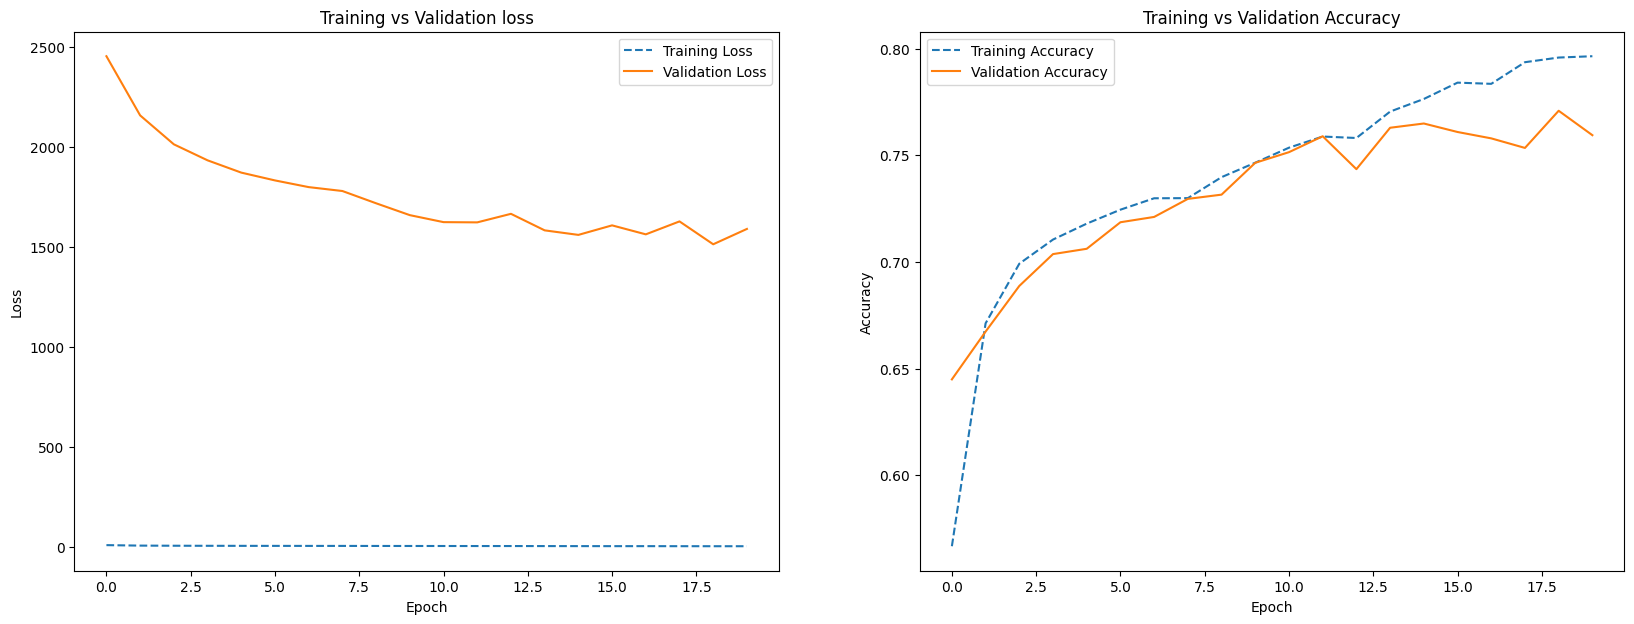

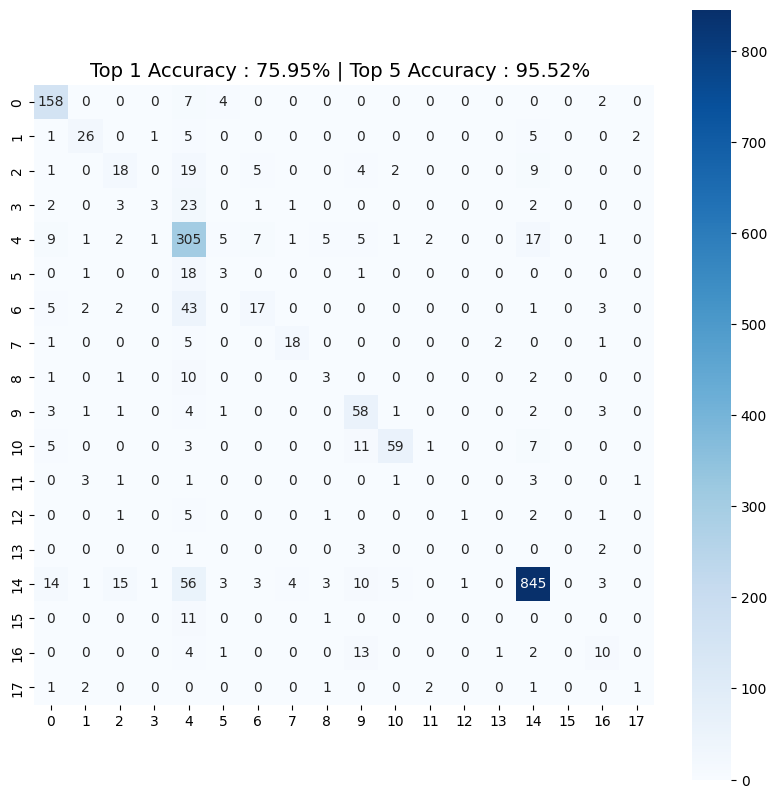

Top 1 Accuracy: 75.946%
Top 5 Accuracy: 95.5179282868526%
Classwise Accuracy Score: 
[0.92397661 0.65       0.31034483 0.08571429 0.84254144 0.13043478
 0.23287671 0.66666667 0.17647059 0.78378378 0.68604651 0.
 0.09090909 0.         0.87655602 0.         0.32258065 0.125     ]


In [227]:
criterion = nn.NLLLoss()
learning_rate = 0.005
n_hidden = 128
n_linear = 128
rnn_stacked = RNNStacked(n_letters, n_hidden,n_linear, n_categories)
optimizer = torch.optim.Adam(rnn_stacked.parameters(),lr= learning_rate)
loss_list = stacked_model_training(rnn_stacked,criterion,optimizer,x_train,y_train,x_test,y_test,num_epochs=5)
plot_training_graphs(loss_list)
with torch.no_grad(): 

    test_output =[]
    for i,line_tensor in enumerate(x_test):  
            test_output.append(rnn_stacked.evaluate(line_tensor))

    confusionMatrixAndAccuracyReport(list_to_nparray(y_test),list_to_nparray(test_output),all_categories)

## 6.2 At last, perform inference on the following words and print their language of origin.

Emilia, Alexandra, Sachiko, Vladimir, Minh, Xi, Muammar, Mukesh, Andrew, Ronaldo

In [228]:
test_name_list = ['Emilia', 'Alexandra', 'Sachiko', 'Vladimir', 'Minh', 'Xi', 'Muammar', 'Mukesh', 'Andrew', 'Ronaldo']

for name in test_name_list:
    rnn.predict(name)



> Emilia
(-0.95) Spanish
(-1.15) Italian
(-2.28) Greek

> Alexandra
(-0.56) Spanish
(-1.88) Czech
(-1.96) Italian

> Sachiko
(-0.51) Japanese
(-1.58) Russian
(-2.13) Czech

> Vladimir
(-0.51) Russian
(-2.02) French
(-2.03) Czech

> Minh
(-0.65) English
(-1.81) Irish
(-1.87) Russian

> Xi
(-1.23) Korean
(-1.31) Vietnamese
(-1.49) Chinese

> Muammar
(-0.19) Arabic
(-2.75) German
(-2.96) English

> Mukesh
(-0.05) Russian
(-4.63) English
(-4.69) Japanese

> Andrew
(-0.69) English
(-1.84) French
(-1.91) German

> Ronaldo
(-0.20) Italian
(-2.60) Spanish
(-2.69) Portuguese
